In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


# Importing Libraries

In [2]:
# Importing the libraries 
import tensorflow as tf
import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
%matplotlib inline

Just Making sure whether the GPU is available or not

In [3]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))


print(tf.config.list_physical_devices('GPU'))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

# Importing Data


In [5]:
# importing the naming the dataset
train_df = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
sub_df = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
train_df.name = "Train Set"
test_df.name = "Test Set"
sub_df.name = "Submission Set"

# Setting the pandas veiw to max
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",150)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [7]:
train_df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

Here we can see that the columns `Name` , `City` , `Profession`, `Sleep Duration`, `Dietary Habits`, `Degree` are all the object columns (features) we might need to work extensively on these columns

In [9]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          93800 non-null  int64
 1   Depression  93800 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


In [10]:
train_df.tail(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
140690,140690,Rashi,Female,18.0,Ludhiana,Student,NaN,5.0,NaN,6.88,2.0,NaN,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1
140691,140691,Zara,Female,57.0,Meerut,Working Professional,Teacher,NaN,1.0,NaN,NaN,1.0,Less than 5 hours,Moderate,B.Arch,Yes,4.0,5.0,Yes,0
140692,140692,Raunak,Male,49.0,Bhopal,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,MBA,No,9.0,1.0,No,0
140693,140693,Shaurya,Male,55.0,Srinagar,Working Professional,Data Scientist,NaN,1.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,M.Tech,No,9.0,2.0,No,0
140694,140694,Ishaani,Female,45.0,Ahmedabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,B.Ed,Yes,1.0,5.0,No,0
140695,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0
140699,140699,Sai,Male,27.0,Patna,Student,NaN,4.0,NaN,9.24,1.0,NaN,Less than 5 hours,Healthy,BCA,Yes,2.0,3.0,Yes,1


In [11]:
# making the id columns as the index
test_df.set_index('id',inplace=True)

# displaying the top ten rows
test_df.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No
140705,Kartik,Male,29.0,Mumbai,Working Professional,Customer Support,NaN,2.0,NaN,NaN,3.0,More than 8 hours,Moderate,B.Com,No,3.0,2.0,Yes
140706,Armaan,Male,47.0,Visakhapatnam,Working Professional,Teacher,NaN,1.0,NaN,NaN,1.0,Less than 5 hours,Healthy,MA,No,10.0,3.0,Yes
140707,Ritika,Female,28.0,Mumbai,Working Professional,Customer Support,NaN,5.0,NaN,NaN,3.0,7-8 hours,Healthy,BA,Yes,0.0,2.0,No
140708,Navya,Female,21.0,Surat,Student,NaN,1.0,NaN,7.39,3.0,NaN,Less than 5 hours,Healthy,BBA,No,8.0,1.0,Yes


In [12]:
sub_df.head(5)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


# EDA

## |> Function Definitions (necessary)

In [13]:
# listing number of unique values 
def listing_nuniques(Ser):
    new_ls = list(set(Ser))
    items=[]
    counts=[]
    for i in range(0,len(new_ls)):
        mask = Ser == new_ls[i]
        items.append(new_ls[i])
        counts.append(mask.sum())
        # cser[new_a_ls[3]]
        # print(f"{i} : for the items {new_a_ls[i]} we have {mask.sum()} no.of occurences")
    # converting the new list into a dataframe and sorting its values into descending order.
    new_pd = pd.DataFrame({"items":items,"counts":counts})
    new_pd.sort_values(by='counts',ascending=False,inplace=True)
    return new_pd


# swapping the values of the series
# def swap_ser_values(ser1,ser2):
#     return ser1,ser2  


# jumpled datas valuation
def identify_jumbled_data(df, target_column):
    #  Identify rows where values in the target column appear in other columns.
    # Parameters:
    #     df (pd.DataFrame): The input dataframe.
    #     target_column (str): The name of the column to check for jumbled data.
    # Returns:
    #     list: Indices of rows where jumbled data is found.
    #**********************************************************************************#
    # # Get all column names except the target column
    # other_columns = df.drop(columns=[target_column])
    # # Identify rows where the target column value exists in any other column
    # jumbled_indices = df.index[df.apply(lambda row: row[target_column] in other_columns.values, axis=1)].tolist()
    # return jumbled_indices
    
    # Ensure the target column exists
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in the dataframe.")
    else :
        # Extract values from the target column
        target_values = df[target_column].values[:, np.newaxis]  # Shape -> (n, 1)
        
        # Exclude the target column and convert the rest of the dataframe to a NumPy array
        other_columns = df.drop(columns=[target_column]).to_numpy()  # Shape -> (n, m-1)
        
        # Check if any value in 'target_column' exists in 'other_columns' row-wise
        mask = np.any(target_values == other_columns, axis=1)  
        
        # Return the indices where jumbled data is found
        return df.index[mask].to_numpy()


def get_index_of_List(Ser,ls):
    if isinstance(Ser, pd.Series) and isinstance(ls, list):    
        # Find indexes where items in the list exist in the Series
        indexes = Ser[Ser.isin(ls)].index.tolist()
        return indexes
    else:
        raise ValueError("Input must be a Pandas Series and a list.")



def replace_with_other_category(ser , ls_unwnt , cate_str):
        # Check if inputs are of the correct types
    if isinstance(ls_unwnt, list) and isinstance(ser, pd.Series) and isinstance(cate_str,str):
        # Create a copy of the Series to avoid modifying the original
        new_ser = ser.copy()
        
        # Use vectorized operation to replace unwanted items
        new_ser[new_ser.isin(ls_unwnt)] = cate_str
        
        return new_ser
    else:
        raise ValueError("Input must be Series , list and string.")


def create_mapping(unique_values):
    """Creates a mapping dictionary for encoding unique values."""
    return {value: i for i, value in enumerate(unique_values)}

def create_mapping_from_column(df, column_name):
    """Creates a mapping dictionary directly from a DataFrame column."""
    unique_values = df[column_name].unique()
    processed = [val.lower() if isinstance(val, str) else val for val in unique_values]
    sorted_values = sorted(processed)
    return create_mapping(sorted_values)  # Return mapping directly

  1.   Let us explore the data and see where the data leads us if there are any missing values like nulls are present or if any duplicate values are present etc.

  2.   What if there are some jumpled values present in the dataframe we will have to perform `train` set and `test` set along to cross verify the final output

## Duplicates Available ?

In [14]:
# check if there are any duplicated field in train and test sets
print(f"Train Set Duplicated sum : {train_df.duplicated().sum()}")
print(f"Test Set Duplicated sum : {test_df.duplicated().sum()}")

Train Set Duplicated sum : 0
Test Set Duplicated sum : 0


## Missing Available ?

Checking if there are any null values in the dataframe (train & test)

In [15]:
# train set
train_df.isna().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

Damn! thats  a lot of null values in a dataframe lets check the same with test set

In [16]:
# test set
test_df.isna().sum()

Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               24632
Academic Pressure                        75033
Work Pressure                            18778
CGPA                                     75034
Study Satisfaction                       75033
Job Satisfaction                         18774
Sleep Duration                               0
Dietary Habits                               5
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
dtype: int64

We can take care of the numerical null values for now for the train and test set

In [17]:
train_df[train_df.select_dtypes(include='number').columns] = train_df.select_dtypes(include='number').fillna(0)
train_df.select_dtypes(include='number')

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
0,0,49.0,0.0,5.0,0.00,0.0,2.0,1.0,2.0,0
1,1,26.0,0.0,4.0,0.00,0.0,3.0,7.0,3.0,1
2,2,33.0,5.0,0.0,8.97,2.0,0.0,3.0,1.0,1
3,3,22.0,0.0,5.0,0.00,0.0,1.0,10.0,1.0,1
4,4,30.0,0.0,1.0,0.00,0.0,1.0,9.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...
140695,140695,18.0,0.0,5.0,0.00,0.0,4.0,2.0,4.0,1
140696,140696,41.0,0.0,5.0,0.00,0.0,4.0,6.0,5.0,0
140697,140697,24.0,0.0,3.0,0.00,0.0,1.0,4.0,4.0,0
140698,140698,49.0,0.0,5.0,0.00,0.0,2.0,10.0,1.0,0


In [18]:
test_df[test_df.select_dtypes(include='number').columns] = test_df.select_dtypes(include='number').fillna(0)
test_df.select_dtypes(include='number')

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
id,,,,,,,,
140700,53.0,0.0,2.0,0.00,0.0,5.0,9.0,3.0
140701,58.0,0.0,2.0,0.00,0.0,4.0,6.0,4.0
140702,53.0,0.0,4.0,0.00,0.0,1.0,12.0,4.0
140703,23.0,5.0,0.0,6.84,1.0,0.0,10.0,4.0
140704,47.0,0.0,5.0,0.00,0.0,5.0,3.0,4.0
...,...,...,...,...,...,...,...,...
234495,49.0,0.0,3.0,0.00,0.0,5.0,2.0,2.0
234496,29.0,0.0,5.0,0.00,0.0,1.0,11.0,3.0
234497,24.0,1.0,0.0,7.51,4.0,0.0,7.0,1.0


## Null Values for Numerical Columns?

In [19]:
# train set
train_df.isna().sum()

id                                           0
Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               36630
Academic Pressure                            0
Work Pressure                                0
CGPA                                         0
Study Satisfaction                           0
Job Satisfaction                             0
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
Depression                                   0
dtype: int64

In [20]:
# test set
test_df.isna().sum()

Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               24632
Academic Pressure                            0
Work Pressure                                0
CGPA                                         0
Study Satisfaction                           0
Job Satisfaction                             0
Sleep Duration                               0
Dietary Habits                               5
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
dtype: int64

## Profession Column Handling Null Values

In [21]:
# listing_nuniques(train_df['Profession'])
train_df[['Age','Working Professional or Student','Profession']]

,Age,Working Professional or Student,Profession
0,49.0,Working Professional,Chef
1,26.0,Working Professional,Teacher
2,33.0,Student,NaN
3,22.0,Working Professional,Teacher
4,30.0,Working Professional,Business Analyst
...,...,...,...
140695,18.0,Working Professional,NaN
140696,41.0,Working Professional,Content Writer
140697,24.0,Working Professional,Marketing Manager
140698,49.0,Working Professional,Plumber


From the above data we get that most of the Null values in the Profession Columns Actually refers to `Students`

In [22]:
train_df['Profession'].fillna('Student',inplace=True)

<ipython-input-22-8a7188796227>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Profession'].fillna('Student',inplace=True)


In [23]:
train_df[['Age','Working Professional or Student','Profession']]

,Age,Working Professional or Student,Profession
0,49.0,Working Professional,Chef
1,26.0,Working Professional,Teacher
2,33.0,Student,Student
3,22.0,Working Professional,Teacher
4,30.0,Working Professional,Business Analyst
...,...,...,...
140695,18.0,Working Professional,Student
140696,41.0,Working Professional,Content Writer
140697,24.0,Working Professional,Marketing Manager
140698,49.0,Working Professional,Plumber


In [24]:
# Now I guess we will do the same with test set
test_df['Profession'].isnull().sum()

24632

In [25]:
test_df[['Age','Working Professional or Student','Profession']]

,Age,Working Professional or Student,Profession
id,,,
140700,53.0,Working Professional,Judge
140701,58.0,Working Professional,Educational Consultant
140702,53.0,Working Professional,Teacher
140703,23.0,Student,NaN
140704,47.0,Working Professional,Teacher
...,...,...,...
234495,49.0,Working Professional,Pilot
234496,29.0,Working Professional,Pilot
234497,24.0,Student,NaN


In [26]:
test_df['Profession'].fillna('Student',inplace=True)

<ipython-input-26-72b645f62f71>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Profession'].fillna('Student',inplace=True)


In [27]:
test_df[['Age','Working Professional or Student','Profession']]

,Age,Working Professional or Student,Profession
id,,,
140700,53.0,Working Professional,Judge
140701,58.0,Working Professional,Educational Consultant
140702,53.0,Working Professional,Teacher
140703,23.0,Student,Student
140704,47.0,Working Professional,Teacher
...,...,...,...
234495,49.0,Working Professional,Pilot
234496,29.0,Working Professional,Pilot
234497,24.0,Student,Student


## Handling Null and Missing Values!!

In [28]:
# checking the train set once more 
train_df.isna().sum()

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           4
Degree                                   2
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [29]:
# re-checking the test set again
test_df.isna().sum()

Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           5
Degree                                   2
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
dtype: int64

### For Diet and Degree column Nul Values

In [30]:
listing_nuniques(train_df['Dietary Habits'])

,items,counts
3,Moderate,49705
16,Unhealthy,46227
12,Healthy,44741
1,Yes,2
10,More Healthy,2
18,No,2
0,Less Healthy,1
2,1.0,1
7,No Healthy,1
6,Class 12,1


In [31]:
listing_nuniques(train_df['Degree'])

,items,counts
69,Class 12,14729
57,B.Ed,11691
72,B.Arch,8742
60,B.Com,8113
100,B.Pharm,5856
103,BCA,5739
111,M.Ed,5668
23,MCA,5234
73,BBA,5030
109,BSc,5027


In [32]:
# I personally think that it is better to remove those null value rows from the dataset for both train and test set
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [33]:
train_df.isna().sum()

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [34]:
test_df.isna().sum()

Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
dtype: int64

As you can see now there are no null values present in the dataframe

<div>
    <center>
        <h2>
           <b><U> Missing Values Handled ^}^</U></b>
        </h2>
    </center>
</div>

## Checking Duplicates again

In [35]:
# check if there are any duplicated field in train and test sets
print(f"Train Set Duplicated sum : {train_df.duplicated().sum()}")
print(f"Test Set Duplicated sum : {test_df.duplicated().sum()}")

Train Set Duplicated sum : 0
Test Set Duplicated sum : 0


#### NO duplicates For NOw

## Data Handling

In [36]:
listing_nuniques(train_df['Name'])

,items,counts
95,Rohan,3178
142,Aarav,2336
45,Rupak,2176
68,Aaradhya,2045
54,Anvi,2034
...,...,...
132,Rhesh,1
136,Aarand,1
137,Virar,1
138,Tani,1


In [37]:
listing_nuniques(train_df['City'])

,items,counts
95,Kalyan,6591
97,Patna,5924
50,Vasai-Virar,5765
46,Kolkata,5689
71,Ahmedabad,5613
26,Meerut,5528
44,Ludhiana,5226
33,Pune,5210
31,Rajkot,5207
63,Visakhapatnam,5176


As you can see there are some uncleaned data that are present here because of wrong entries from the applicants I Guess , 

**Problem** : There are data from other features or columns present in this particular column however it should have been specific to this column features only but we ended up having them 

**Solutions** : Since there are jumbled up data here and there , I think we wil lhave to sort it out between these columns itself. Therefore We'll have to cross verify all columns with all the other columns which has object as the datatype.


"*The Solution That I've provided is personal but those of you who can deal with it in particular please go ahead if you find way better solutions than this please do tag me on the solutions if you guys obtain some , So that I can improve myself here as well*"

# Data Preprocessing

In [38]:
train_df.select_dtypes(include='object')

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
0,Aaradhya,Female,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,No
1,Vivan,Male,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,No
2,Yuvraj,Male,Visakhapatnam,Student,Student,5-6 hours,Healthy,B.Pharm,Yes,No
3,Yuvraj,Male,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,Yes
4,Rhea,Female,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...
140695,Vidya,Female,Ahmedabad,Working Professional,Student,5-6 hours,Unhealthy,Class 12,No,Yes
140696,Lata,Female,Hyderabad,Working Professional,Content Writer,7-8 hours,Moderate,B.Tech,Yes,Yes
140697,Aanchal,Female,Kolkata,Working Professional,Marketing Manager,More than 8 hours,Moderate,B.Com,No,No
140698,Prachi,Female,Srinagar,Working Professional,Plumber,5-6 hours,Moderate,ME,Yes,No


We will eventually work with these seven columns 
1. Name
2. City
3. Working Professional or Student
4. Profession
5. Sleep Duration
6. Dietary Habits
7. Degree

In [39]:
obj_train_set = train_df[['id','Name','City','Working Professional or Student','Profession','Sleep Duration','Dietary Habits','Degree']]
obj_train_set

,id,Name,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree
0,0,Aaradhya,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM
1,1,Vivan,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB
2,2,Yuvraj,Visakhapatnam,Student,Student,5-6 hours,Healthy,B.Pharm
3,3,Yuvraj,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA
4,4,Rhea,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA
...,...,...,...,...,...,...,...,...
140695,140695,Vidya,Ahmedabad,Working Professional,Student,5-6 hours,Unhealthy,Class 12
140696,140696,Lata,Hyderabad,Working Professional,Content Writer,7-8 hours,Moderate,B.Tech
140697,140697,Aanchal,Kolkata,Working Professional,Marketing Manager,More than 8 hours,Moderate,B.Com
140698,140698,Prachi,Srinagar,Working Professional,Plumber,5-6 hours,Moderate,ME


In [40]:
indicies_to_remove = list()
indicies_to_remove.append(list(identify_jumbled_data(obj_train_set,'Name')))

In [41]:
indicies_to_remove

[[191,
  3753,
  4142,
  12371,
  12526,
  15919,
  20390,
  28852,
  28927,
  45721,
  52500,
  58776,
  61812,
  63149,
  64081,
  64786,
  76544,
  76656,
  80787,
  87539,
  89484,
  90830,
  92096,
  96088,
  96190,
  99716,
  100365,
  100484,
  102845,
  103298,
  107341,
  107947,
  110828,
  118660,
  125085,
  129159,
  129275,
  134485,
  135269,
  136453]]

In [42]:
indicies_to_remove.append(list(identify_jumbled_data(obj_train_set,'City')))

In [43]:
indicies_to_remove

[[191,
  3753,
  4142,
  12371,
  12526,
  15919,
  20390,
  28852,
  28927,
  45721,
  52500,
  58776,
  61812,
  63149,
  64081,
  64786,
  76544,
  76656,
  80787,
  87539,
  89484,
  90830,
  92096,
  96088,
  96190,
  99716,
  100365,
  100484,
  102845,
  103298,
  107341,
  107947,
  110828,
  118660,
  125085,
  129159,
  129275,
  134485,
  135269,
  136453],
 [191,
  3753,
  4142,
  12371,
  13315,
  15919,
  28672,
  28852,
  45721,
  52500,
  58776,
  60931,
  61812,
  64081,
  76544,
  80787,
  87539,
  89484,
  90830,
  96034,
  96088,
  96190,
  99716,
  100365,
  100484,
  102845,
  103298,
  105684,
  107947,
  110828,
  118660,
  121697,
  125085,
  129159,
  134485,
  135269,
  136453]]

In [44]:
indicies_to_remove.append(list(identify_jumbled_data(obj_train_set,'Sleep Duration')))
indicies_to_remove.append(list(identify_jumbled_data(obj_train_set,'Degree')))
indicies_to_remove.append(list(identify_jumbled_data(obj_train_set,'Dietary Habits')))

In [45]:
indicies_to_remove

[[191,
  3753,
  4142,
  12371,
  12526,
  15919,
  20390,
  28852,
  28927,
  45721,
  52500,
  58776,
  61812,
  63149,
  64081,
  64786,
  76544,
  76656,
  80787,
  87539,
  89484,
  90830,
  92096,
  96088,
  96190,
  99716,
  100365,
  100484,
  102845,
  103298,
  107341,
  107947,
  110828,
  118660,
  125085,
  129159,
  129275,
  134485,
  135269,
  136453],
 [191,
  3753,
  4142,
  12371,
  13315,
  15919,
  28672,
  28852,
  45721,
  52500,
  58776,
  60931,
  61812,
  64081,
  76544,
  80787,
  87539,
  89484,
  90830,
  96034,
  96088,
  96190,
  99716,
  100365,
  100484,
  102845,
  103298,
  105684,
  107947,
  110828,
  118660,
  121697,
  125085,
  129159,
  134485,
  135269,
  136453],
 [79764, 94888],
 [8957,
  10782,
  13315,
  14641,
  20390,
  21693,
  22850,
  28672,
  36669,
  37181,
  45238,
  45355,
  51375,
  56846,
  74718,
  76656,
  80662,
  81242,
  94753,
  97130,
  107341,
  112942,
  131669,
  133347],
 [79764, 94888]]

In [46]:
print(len(indicies_to_remove))

5


In [47]:
# Now we will  flatten the array indicies_to_remove

flattened_indexes = list(chain.from_iterable(indicies_to_remove))

flattened_indexes = set(flattened_indexes)

flattened_indexes

{191,
 3753,
 4142,
 8957,
 10782,
 12371,
 12526,
 13315,
 14641,
 15919,
 20390,
 21693,
 22850,
 28672,
 28852,
 28927,
 36669,
 37181,
 45238,
 45355,
 45721,
 51375,
 52500,
 56846,
 58776,
 60931,
 61812,
 63149,
 64081,
 64786,
 74718,
 76544,
 76656,
 79764,
 80662,
 80787,
 81242,
 87539,
 89484,
 90830,
 92096,
 94753,
 94888,
 96034,
 96088,
 96190,
 97130,
 99716,
 100365,
 100484,
 102845,
 103298,
 105684,
 107341,
 107947,
 110828,
 112942,
 118660,
 121697,
 125085,
 129159,
 129275,
 131669,
 133347,
 134485,
 135269,
 136453}

In [48]:
print(len(flattened_indexes))

67


In [49]:
# Removing the jumbled data from the train set
train_df.drop(index=flattened_indexes,inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140627 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140627 non-null  int64  
 1   Name                                   140627 non-null  object 
 2   Gender                                 140627 non-null  object 
 3   Age                                    140627 non-null  float64
 4   City                                   140627 non-null  object 
 5   Working Professional or Student        140627 non-null  object 
 6   Profession                             140627 non-null  object 
 7   Academic Pressure                      140627 non-null  float64
 8   Work Pressure                          140627 non-null  float64
 9   CGPA                                   140627 non-null  float64
 10  Study Satisfaction                     140627 non-null  float

In [50]:
140700-140627

73

## Applying the former jumbled data solution to the test set as well

In [51]:
obj_test_set = test_df[['Name','City','Working Professional or Student','Profession','Sleep Duration','Dietary Habits','Degree']]
obj_test_set

,Name,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree
id,,,,,,,
140700,Shivam,Visakhapatnam,Working Professional,Judge,Less than 5 hours,Moderate,LLB
140701,Sanya,Kolkata,Working Professional,Educational Consultant,Less than 5 hours,Moderate,B.Ed
140702,Yash,Jaipur,Working Professional,Teacher,7-8 hours,Moderate,B.Arch
140703,Nalini,Rajkot,Student,Student,More than 8 hours,Moderate,BSc
140704,Shaurya,Kalyan,Working Professional,Teacher,7-8 hours,Moderate,BCA
...,...,...,...,...,...,...,...
234495,Zoya,Jaipur,Working Professional,Pilot,Less than 5 hours,Moderate,BSc
234496,Shlok,Ahmedabad,Working Professional,Pilot,7-8 hours,Moderate,BE
234497,Rishi,Visakhapatnam,Student,Student,7-8 hours,Moderate,B.Tech


In [52]:
test_indexes = list()
test_indexes.append(list(identify_jumbled_data(obj_test_set,'Name')))
test_indexes.append(list(identify_jumbled_data(obj_test_set,'City')))
test_indexes.append(list(identify_jumbled_data(obj_test_set,'Sleep Duration')))
test_indexes.append(list(identify_jumbled_data(obj_test_set,'Dietary Habits')))
test_indexes.append(list(identify_jumbled_data(obj_test_set,'Degree')))
test_indexes


[[142249,
  142439,
  144929,
  144934,
  153947,
  154104,
  163990,
  164138,
  165912,
  169985,
  175205,
  179751,
  181969,
  184214,
  186011,
  187671,
  187818,
  190171,
  192455,
  198805,
  199569,
  203391,
  206022,
  210274,
  219853,
  227257,
  228683,
  229124,
  229940,
  230710,
  231703],
 [142249,
  142439,
  144929,
  144934,
  154104,
  163990,
  164138,
  164573,
  175205,
  178791,
  179751,
  181969,
  184214,
  186011,
  187671,
  190162,
  190171,
  192455,
  198805,
  199569,
  203391,
  206022,
  210274,
  211103,
  219853,
  227257,
  228683,
  231703],
 [161326],
 [141166, 153947, 158433, 161326],
 [141952, 148594, 161634, 165912, 181298, 205934, 226538, 229940, 230710]]

In [53]:
test_flattened_indexes = list(chain.from_iterable(test_indexes))
test_flattened_indexes = set(test_flattened_indexes)
test_flattened_indexes

{141166,
 141952,
 142249,
 142439,
 144929,
 144934,
 148594,
 153947,
 154104,
 158433,
 161326,
 161634,
 163990,
 164138,
 164573,
 165912,
 169985,
 175205,
 178791,
 179751,
 181298,
 181969,
 184214,
 186011,
 187671,
 187818,
 190162,
 190171,
 192455,
 198805,
 199569,
 203391,
 205934,
 206022,
 210274,
 211103,
 219853,
 226538,
 227257,
 228683,
 229124,
 229940,
 230710,
 231703}

In [54]:
print(len(test_flattened_indexes))

44


In [55]:
# dropping the jumpled data on the test set

test_df.drop(index = test_flattened_indexes ,inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93749 entries, 140700 to 234499
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   93749 non-null  object 
 1   Gender                                 93749 non-null  object 
 2   Age                                    93749 non-null  float64
 3   City                                   93749 non-null  object 
 4   Working Professional or Student        93749 non-null  object 
 5   Profession                             93749 non-null  object 
 6   Academic Pressure                      93749 non-null  float64
 7   Work Pressure                          93749 non-null  float64
 8   CGPA                                   93749 non-null  float64
 9   Study Satisfaction                     93749 non-null  float64
 10  Job Satisfaction                       93749 non-null  float64
 11  S

In [56]:
93800-93749

51

## Validating the preprocessing steps

In [57]:
train_df.select_dtypes(include='object')

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
0,Aaradhya,Female,Ludhiana,Working Professional,Chef,More than 8 hours,Healthy,BHM,No,No
1,Vivan,Male,Varanasi,Working Professional,Teacher,Less than 5 hours,Unhealthy,LLB,Yes,No
2,Yuvraj,Male,Visakhapatnam,Student,Student,5-6 hours,Healthy,B.Pharm,Yes,No
3,Yuvraj,Male,Mumbai,Working Professional,Teacher,Less than 5 hours,Moderate,BBA,Yes,Yes
4,Rhea,Female,Kanpur,Working Professional,Business Analyst,5-6 hours,Unhealthy,BBA,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...
140695,Vidya,Female,Ahmedabad,Working Professional,Student,5-6 hours,Unhealthy,Class 12,No,Yes
140696,Lata,Female,Hyderabad,Working Professional,Content Writer,7-8 hours,Moderate,B.Tech,Yes,Yes
140697,Aanchal,Female,Kolkata,Working Professional,Marketing Manager,More than 8 hours,Moderate,B.Com,No,No
140698,Prachi,Female,Srinagar,Working Professional,Plumber,5-6 hours,Moderate,ME,Yes,No


In [58]:
test_df.select_dtypes(include='object')

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
id,,,,,,,,,,
140700,Shivam,Male,Visakhapatnam,Working Professional,Judge,Less than 5 hours,Moderate,LLB,No,Yes
140701,Sanya,Female,Kolkata,Working Professional,Educational Consultant,Less than 5 hours,Moderate,B.Ed,No,No
140702,Yash,Male,Jaipur,Working Professional,Teacher,7-8 hours,Moderate,B.Arch,Yes,No
140703,Nalini,Female,Rajkot,Student,Student,More than 8 hours,Moderate,BSc,Yes,No
140704,Shaurya,Male,Kalyan,Working Professional,Teacher,7-8 hours,Moderate,BCA,Yes,No
...,...,...,...,...,...,...,...,...,...,...
234495,Zoya,Female,Jaipur,Working Professional,Pilot,Less than 5 hours,Moderate,BSc,Yes,Yes
234496,Shlok,Male,Ahmedabad,Working Professional,Pilot,7-8 hours,Moderate,BE,Yes,Yes
234497,Rishi,Male,Visakhapatnam,Student,Student,7-8 hours,Moderate,B.Tech,No,No


In [59]:
train_df[['Name','City','Profession','Dietary Habits','Degree']] = train_df[['Name','City','Profession','Dietary Habits','Degree']].apply(lambda x:x.str.lower())

In [60]:
test_df[['Name','City','Profession','Dietary Habits','Degree']] = test_df[['Name','City','Profession','Dietary Habits','Degree']].apply(lambda x:x.str.lower())

In [61]:
train_df['Degree'] = train_df['Degree'].str.replace('.','',regex=False)
test_df['Degree'] = test_df['Degree'].str.replace('.','',regex=False)

In [62]:
name_col_train = listing_nuniques(train_df['Name'])
name_col_train

,items,counts
220,rohan,3176
373,aarav,2335
193,rupak,2176
141,aaradhya,2045
275,anvi,2034
...,...,...
130,ryouvik,1
132,parha,1
133,ayash,1
135,anahk,1


In [63]:
city_col_train = listing_nuniques(train_df['City'])
city_col_train

,items,counts
18,kalyan,6573
81,patna,5920
78,vasai-virar,5763
82,kolkata,5686
11,ahmedabad,5612
72,meerut,5527
7,ludhiana,5226
92,pune,5210
35,rajkot,5204
57,visakhapatnam,5175


In [64]:
degree_col_train = listing_nuniques(train_df['Degree'])
degree_col_train

,items,counts
89,class 12,14726
71,bed,11687
3,barch,8739
73,bcom,8108
31,bpharm,5856
45,bca,5736
35,med,5667
36,mca,5232
99,bsc,5027
95,bba,5027


In [65]:
degree_col_test = listing_nuniques(test_df['Degree'])
degree_col_test

,items,counts
47,class 12,9807
57,bed,7759
16,barch,6035
61,bcom,5439
14,bpharm,3987
59,bca,3869
27,med,3705
28,mca,3437
65,bba,3385
73,bsc,3317


From the Degree Unique item list we can see that any item below the count of 5 is an unecessary risk for the data so we will remove them from the main train and test data

In [66]:
train_degree_col_unwanted_item_list = list(degree_col_train[degree_col_train['counts']<5]['items'])
test_degree_col_unwanted_item_list = list(degree_col_test[degree_col_test['counts']<5]['items'])

In [67]:
city_col_test = listing_nuniques(test_df['City'])


city_col_train_ls = list(city_col_train[city_col_train['counts']<10]['items'])
city_col_test_ls = list(city_col_test[city_col_test['counts']<10]['items'])

In [68]:
profession_col_test = listing_nuniques(test_df['Profession'])
profession_col_train = listing_nuniques(train_df['Profession'])


profession_col_train_ls = list(profession_col_train[profession_col_train['counts']<10]['items'])
profession_col_test_ls = list(profession_col_test[profession_col_test['counts']<10]['items'])

In [69]:
diet_col_test = listing_nuniques(test_df['Dietary Habits'])
diet_col_train = listing_nuniques(train_df['Dietary Habits'])


diet_col_train_ls = list(diet_col_train[diet_col_train['counts']<10]['items'])
diet_col_test_ls = list(diet_col_test[diet_col_test['counts']<10]['items'])

In [70]:
listing_nuniques(train_df['Sleep Duration'])

,items,counts
5,Less than 5 hours,38764
6,7-8 hours,36946
30,More than 8 hours,32712
34,5-6 hours,32128
8,3-4 hours,12
27,6-7 hours,8
31,4-5 hours,7
20,2-3 hours,5
3,4-6 hours,5
26,No,4


In [71]:
listing_nuniques(test_df['Sleep Duration'])

,items,counts
2,Less than 5 hours,25646
3,7-8 hours,24479
25,More than 8 hours,22181
28,5-6 hours,21390
22,6-7 hours,7
0,8-9 hours,6
26,4-5 hours,6
15,2-3 hours,4
4,3-4 hours,3
12,9-5 hours,2


In [72]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('7-8 hours','5-8 hours',regex=False)

In [73]:
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('7-8 hours','5-8 hours',regex=False)

In [74]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('5-6 hours','5-8 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('5-6 hours','5-8 hours',regex=False)

In [75]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('3-4 hours','Less than 5 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('3-4 hours','Less than 5 hours',regex=False)

In [76]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('6-7 hours','5-8 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('6-7 hours','5-8 hours',regex=False)

In [77]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('4-5 hours','Less than 5 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('4-5 hours','Less than 5 hours',regex=False)

In [78]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('2-3 hours','Less than 5 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('2-3 hours','Less than 5 hours',regex=False)

In [79]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('4-6 hours','5-8 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('4-6 hours','5-8 hours',regex=False)

In [80]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('6-8 hours','5-8 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('6-8 hours','5-8 hours',regex=False)

In [81]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('1-6 hours','5-8 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('1-6 hours','5-8 hours',regex=False)

In [82]:
train_df['Sleep Duration'] = train_df['Sleep Duration'].str.replace('8-9 hours','More than 8 hours',regex=False)
test_df['Sleep Duration'] = test_df['Sleep Duration'].str.replace('8-9 hours','More than 8 hours',regex=False)

In [83]:
slpdur_col_test = listing_nuniques(test_df['Sleep Duration'])
slpdur_col_train = listing_nuniques(train_df['Sleep Duration'])


slpdur_col_train_ls = list(slpdur_col_train[slpdur_col_train['counts']<5]['items'])
slpdur_col_test_ls = list(slpdur_col_test[slpdur_col_test['counts']<5]['items'])


## Converting into `others` Category for all object column Datatypes

### CITY col

In [84]:
train_df['City'] = replace_with_other_category(train_df['City'], city_col_train_ls , 'Others')

In [85]:
test_df['City'] = replace_with_other_category(test_df['City'], city_col_test_ls , 'Others')

### PROFESSION col

In [86]:
train_df['Profession'] = replace_with_other_category(train_df['Profession'], profession_col_train_ls , 'Others')
test_df['Profession'] = replace_with_other_category(test_df['Profession'], profession_col_test_ls , 'Others')

### SLEEP DURATION col

In [87]:
train_df['Sleep Duration'] = replace_with_other_category(train_df['Sleep Duration'], slpdur_col_train_ls , 'Others')
test_df['Sleep Duration'] = replace_with_other_category(test_df['Sleep Duration'], slpdur_col_test_ls , 'Others')

### DIETARY HABITS col

In [88]:
train_df['Dietary Habits'] = replace_with_other_category(train_df['Dietary Habits'], diet_col_train_ls , 'Others')
test_df['Dietary Habits'] = replace_with_other_category(test_df['Dietary Habits'], diet_col_test_ls , 'Others')

### DEGREE col

In [89]:
test_df['Degree'].unique()

array(['llb', 'bed', 'barch', 'bsc', 'bca', 'bcom', 'ma', 'ba', 'bba',
       'class 12', 'md', 'mba', 'med', 'mpharm', 'bhm', 'llm', 'phd',
       'mcom', 'be', 'mbbs', 'btech', 'me', 'mca', 'bpharm', 'mhm',
       'mtech', 'msc', 'b gender', 'bstudy_hours', 'advait', 'march',
       'aed', 'bh', 'b', 'mui', 'vibha', 'b bca', 'bpress', 'gagan',
       '565', 'business analyst', 'eshita', 'b_com', 'navya', 'b_pharm',
       'pune', 'bian', 'bmcom', 'kavya', 'mmed', 'spharm', 'vrinda', 'm',
       'eed', '30', 'moham', 'ied', 'degree', 'magan', 'b btech', 'mbed',
       'bhopal', 'b financial analyst', 'gca', 'ged', 'rupak', 'rca',
       'pca', 'jed', '895', '20', 'banchal', 'ked', 'bhca'], dtype=object)

In [90]:
train_df['Degree'] = replace_with_other_category(train_df['Degree'], train_degree_col_unwanted_item_list , 'Others')
test_df['Degree'] = replace_with_other_category(test_df['Degree'], test_degree_col_unwanted_item_list , 'Others')

In [91]:
train_df.head(5)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,aaradhya,Female,49.0,ludhiana,Working Professional,chef,0.0,5.0,0.00,0.0,2.0,More than 8 hours,healthy,bhm,No,1.0,2.0,No,0
1,1,vivan,Male,26.0,varanasi,Working Professional,teacher,0.0,4.0,0.00,0.0,3.0,Less than 5 hours,unhealthy,llb,Yes,7.0,3.0,No,1
2,2,yuvraj,Male,33.0,visakhapatnam,Student,student,5.0,0.0,8.97,2.0,0.0,5-8 hours,healthy,bpharm,Yes,3.0,1.0,No,1
3,3,yuvraj,Male,22.0,mumbai,Working Professional,teacher,0.0,5.0,0.00,0.0,1.0,Less than 5 hours,moderate,bba,Yes,10.0,1.0,Yes,1
4,4,rhea,Female,30.0,kanpur,Working Professional,business analyst,0.0,1.0,0.00,0.0,1.0,5-8 hours,unhealthy,bba,Yes,9.0,4.0,Yes,0


# Data Prenups


In [92]:
print(f"TRAIN SET")
for col in train_df.columns:
    print(f"Unique values in '{col}':")
    print(train_df[col].unique())
    print("-" * 50)  # Separator for readability

print('+'*90)
print('`'*90)

print(f"TEST SET")
for col in test_df.columns:
    print(f"Unique values in '{col}':")
    print(test_df[col].unique())
    print("-" * 50)  # Separator for readability

TRAIN SET
Unique values in 'id':
[     0      1      2 ... 140697 140698 140699]
--------------------------------------------------
Unique values in 'Name':
['aaradhya' 'vivan' 'yuvraj' 'rhea' 'vani' 'ritvik' 'rajveer' 'aishwarya'
 'simran' 'utkarsh' 'aahana' 'tejas' 'aadhya' 'kiran' 'aditi' 'suhani'
 'jiya' 'bhavesh' 'armaan' 'ishaani' 'prachi' 'pratyush' 'abhinav'
 'siddhesh' 'aditya' 'aarav' 'asha' 'kashish' 'prisha' 'chhavi' 'tanmay'
 'vihaan' 'shiv' 'anvi' 'darsh' 'samar' 'raunak' 'mahi' 'shaurya' 'vidya'
 'jai' 'ayush' 'ansh' 'anand' 'yashvi' 'shrey' 'ritika' 'mihir' 'isha'
 'arjun' 'rohan' 'pratham' 'nirvaan' 'ishaan' 'aarya' 'riya' 'aariv'
 'raghavendra' 'mahika' 'abhishek' 'harshil' 'janvi' 'kartikeya' 'shivam'
 'advait' 'reyansh' 'saanvi' 'ivaan' 'pallavi' 'sneha' 'ayaan' 'aakash'
 'raghav' 'satyam' 'aarush' 'vibha' 'rupal' 'sanya' 'mira' 'rashi' 'shlok'
 'harsha' 'divya' 'pranav' 'hrithik' 'tushar' 'garima' 'zoya' 'kian'
 'navya' 'lakshay' 'kriti' 'palak' 'aryan' 'parth' 'is

### checking for any duplicates or missing values!

In [93]:
# check if there are any duplicated field in train and test sets
print(f"Train Set Duplicated sum : {train_df.duplicated().sum()}")
print(f"Test Set Duplicated sum : {test_df.duplicated().sum()}")

Train Set Duplicated sum : 0
Test Set Duplicated sum : 0


In [94]:
train_df.isna().sum()

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [95]:
train_df.isna().sum()

id                                       0
Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

# Visualization

In [96]:
train_df

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,aaradhya,Female,49.0,ludhiana,Working Professional,chef,0.0,5.0,0.00,0.0,2.0,More than 8 hours,healthy,bhm,No,1.0,2.0,No,0
1,1,vivan,Male,26.0,varanasi,Working Professional,teacher,0.0,4.0,0.00,0.0,3.0,Less than 5 hours,unhealthy,llb,Yes,7.0,3.0,No,1
2,2,yuvraj,Male,33.0,visakhapatnam,Student,student,5.0,0.0,8.97,2.0,0.0,5-8 hours,healthy,bpharm,Yes,3.0,1.0,No,1
3,3,yuvraj,Male,22.0,mumbai,Working Professional,teacher,0.0,5.0,0.00,0.0,1.0,Less than 5 hours,moderate,bba,Yes,10.0,1.0,Yes,1
4,4,rhea,Female,30.0,kanpur,Working Professional,business analyst,0.0,1.0,0.00,0.0,1.0,5-8 hours,unhealthy,bba,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,vidya,Female,18.0,ahmedabad,Working Professional,student,0.0,5.0,0.00,0.0,4.0,5-8 hours,unhealthy,class 12,No,2.0,4.0,Yes,1
140696,140696,lata,Female,41.0,hyderabad,Working Professional,content writer,0.0,5.0,0.00,0.0,4.0,5-8 hours,moderate,btech,Yes,6.0,5.0,Yes,0
140697,140697,aanchal,Female,24.0,kolkata,Working Professional,marketing manager,0.0,3.0,0.00,0.0,1.0,More than 8 hours,moderate,bcom,No,4.0,4.0,No,0
140698,140698,prachi,Female,49.0,srinagar,Working Professional,plumber,0.0,5.0,0.00,0.0,2.0,5-8 hours,moderate,me,Yes,10.0,1.0,No,0


In [97]:
test_df

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,shivam,Male,53.0,visakhapatnam,Working Professional,judge,0.0,2.0,0.00,0.0,5.0,Less than 5 hours,moderate,llb,No,9.0,3.0,Yes
140701,sanya,Female,58.0,kolkata,Working Professional,educational consultant,0.0,2.0,0.00,0.0,4.0,Less than 5 hours,moderate,bed,No,6.0,4.0,No
140702,yash,Male,53.0,jaipur,Working Professional,teacher,0.0,4.0,0.00,0.0,1.0,5-8 hours,moderate,barch,Yes,12.0,4.0,No
140703,nalini,Female,23.0,rajkot,Student,student,5.0,0.0,6.84,1.0,0.0,More than 8 hours,moderate,bsc,Yes,10.0,4.0,No
140704,shaurya,Male,47.0,kalyan,Working Professional,teacher,0.0,5.0,0.00,0.0,5.0,5-8 hours,moderate,bca,Yes,3.0,4.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234495,zoya,Female,49.0,jaipur,Working Professional,pilot,0.0,3.0,0.00,0.0,5.0,Less than 5 hours,moderate,bsc,Yes,2.0,2.0,Yes
234496,shlok,Male,29.0,ahmedabad,Working Professional,pilot,0.0,5.0,0.00,0.0,1.0,5-8 hours,moderate,be,Yes,11.0,3.0,Yes
234497,rishi,Male,24.0,visakhapatnam,Student,student,1.0,0.0,7.51,4.0,0.0,5-8 hours,moderate,btech,No,7.0,1.0,No


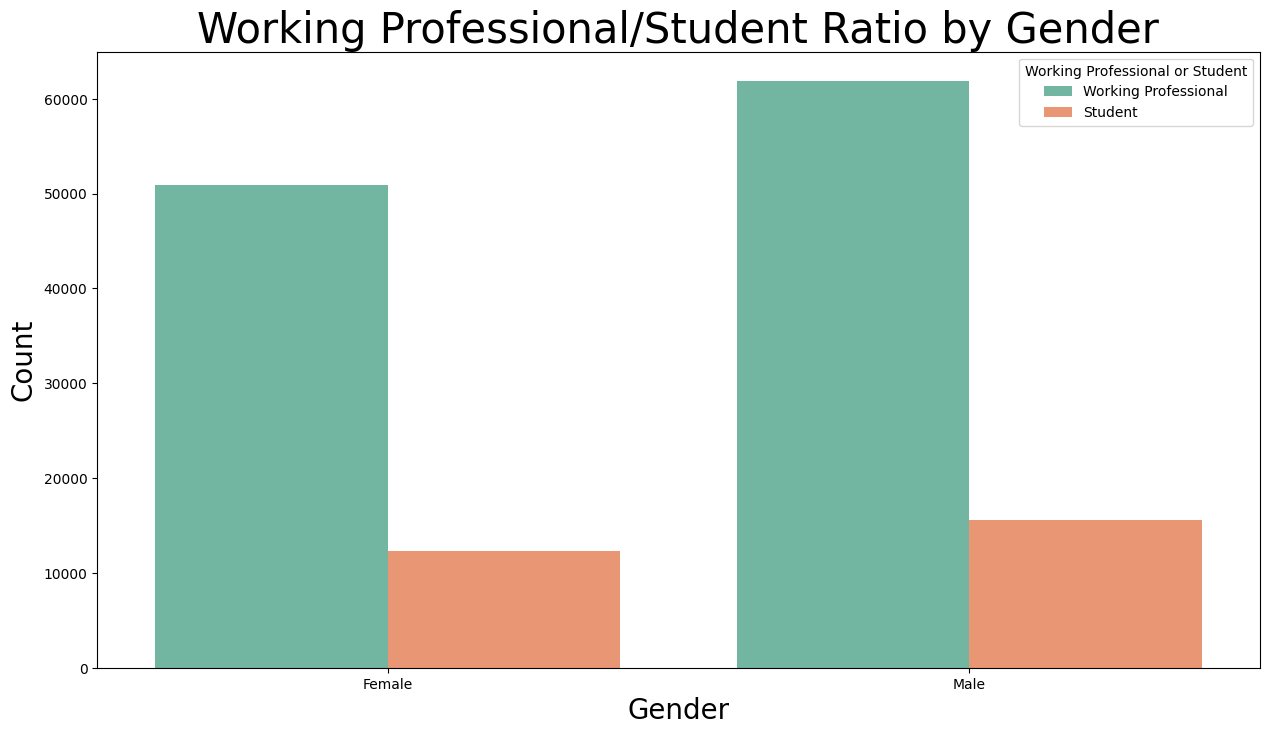

In [98]:
# Working Professional and Student Ratio

plt.figure(figsize=(15, 8))

# Use sns.countplot to count occurrences and split by hue
sns.countplot(data=train_df, 
              x="Gender", 
              hue="Working Professional or Student", 
              palette="Set2")

# Add labels and title
plt.title("Working Professional/Student Ratio by Gender",fontsize=30)
plt.xlabel("Gender",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.legend(title="Working Professional or Student")

plt.show()

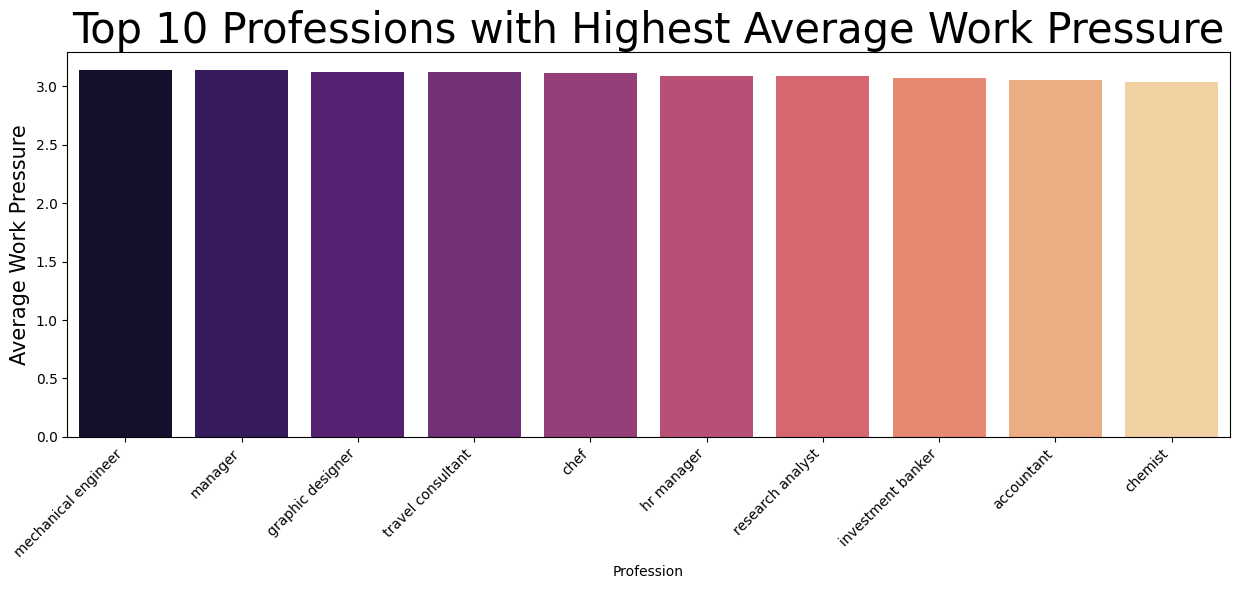

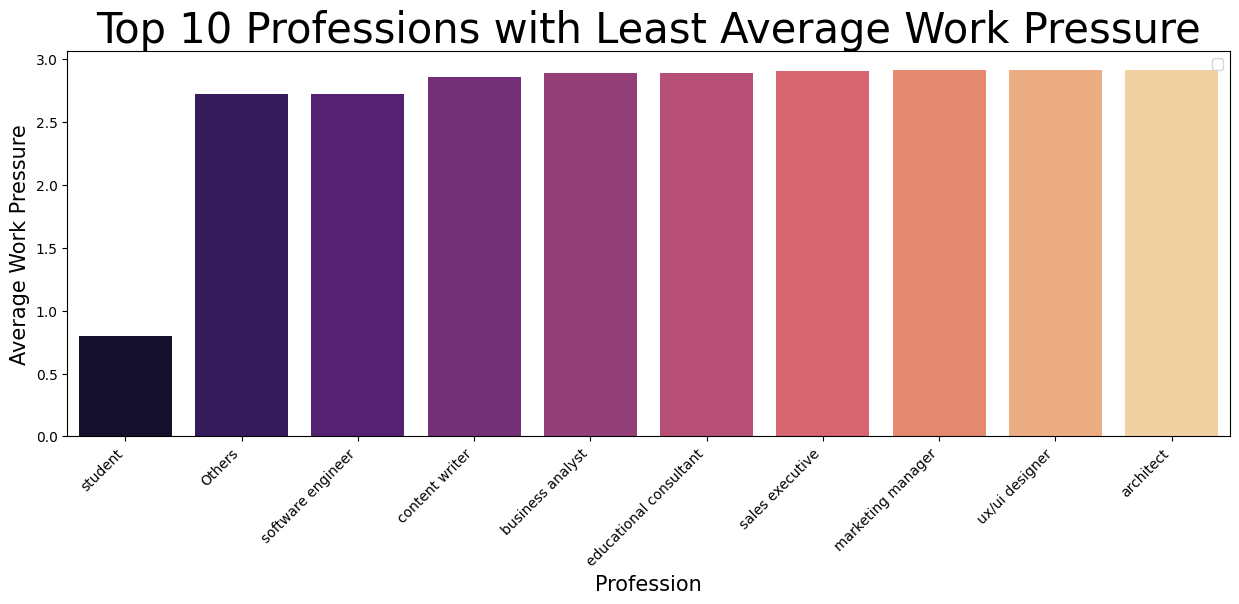

In [99]:
# Group by Profession and calculate the mean work pressure
avg_work_pressure_by_profession = (
    train_df.groupby('Profession', as_index=False)['Work Pressure'].mean()
)

# Sort by work pressure in descending order
top10_workPressured_jobs = avg_work_pressure_by_profession.sort_values(
    by='Work Pressure', ascending=False
)

# Plotting the graph
plt.figure(figsize=(15, 5))  # Adjusted figure size for better readability

sns.barplot(data=top10_workPressured_jobs.head(10),
            x="Profession",
            y="Work Pressure",
            palette="magma")  # Added a color palette for better visuals

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylabel("Average Work Pressure",fontsize=15)
plt.title("Top 10 Professions with Highest Average Work Pressure",fontsize=30)


# Sort by work pressure in descending order
top10_workPressured_jobs = avg_work_pressure_by_profession.sort_values(
    by='Work Pressure', ascending=True
)

# Plotting the graph
plt.figure(figsize=(15, 5))  # Adjusted figure size for better readability

sns.barplot(data=top10_workPressured_jobs.head(10),
            x="Profession",
            y="Work Pressure",
            palette="magma")  # Added a color palette for better visuals

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel("Profession",fontsize=15)
plt.ylabel("Average Work Pressure",fontsize=15)
plt.title("Top 10 Professions with Least Average Work Pressure",fontsize=30)

plt.legend()
plt.show()

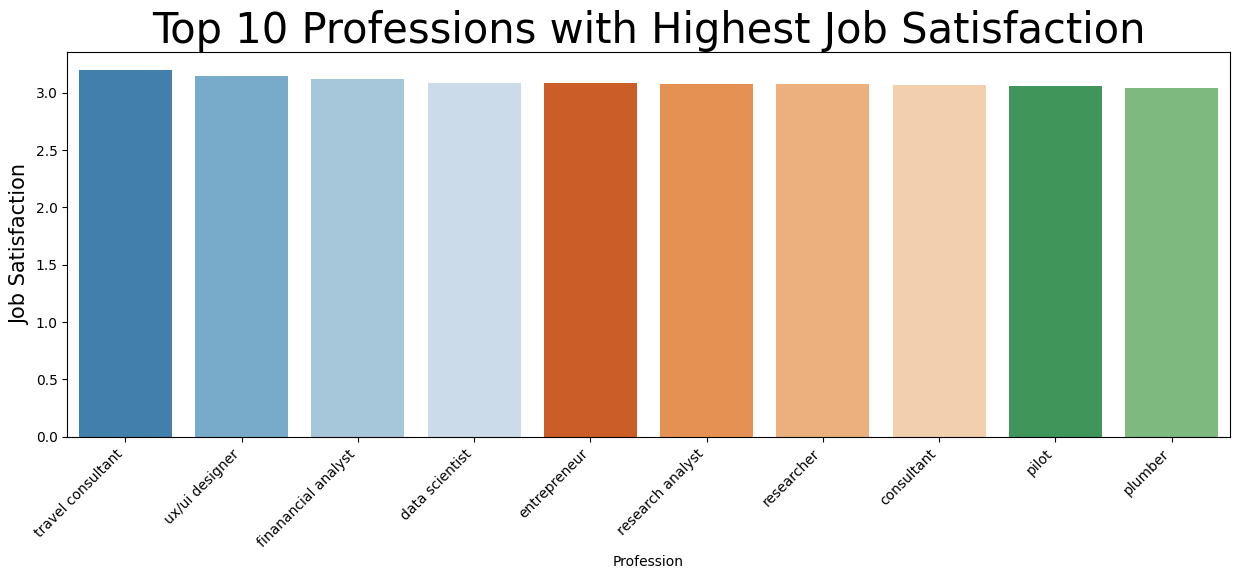

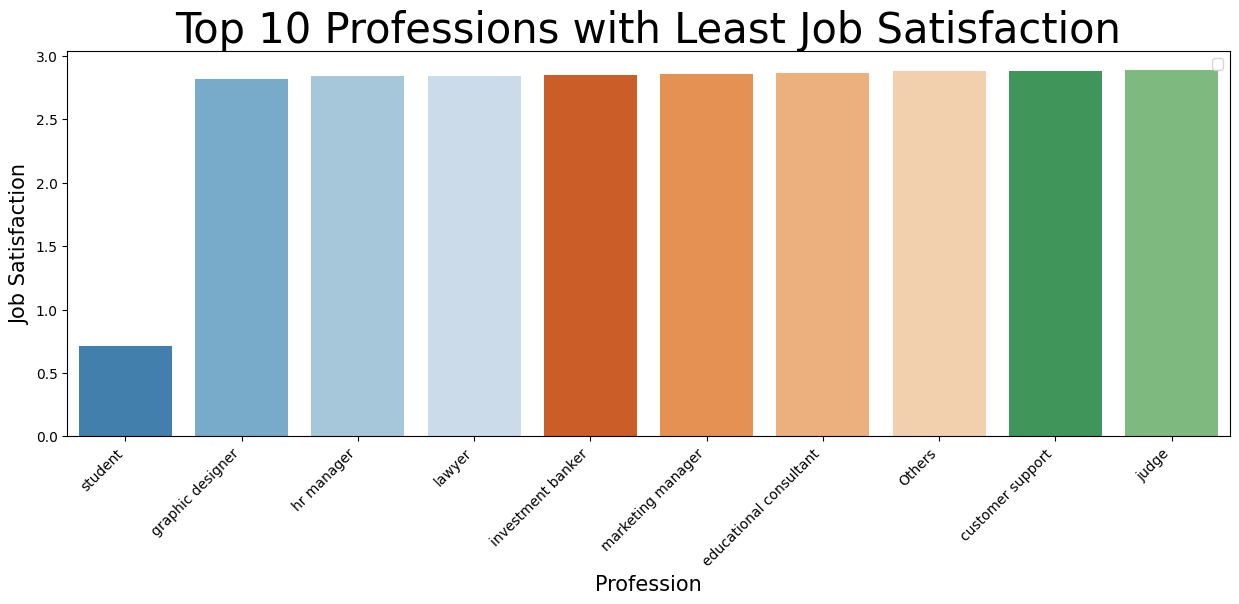

In [100]:
# Group by Profession and calculate the mean job satisfaction
avg_job_satisfaction_by_profession = (
    train_df.groupby('Profession', as_index=False)['Job Satisfaction'].mean()
)

# Sort by  job satisfaction in descending order
top10_jobsatisfaction_jobs = avg_job_satisfaction_by_profession.sort_values(
    by='Job Satisfaction', ascending=False
)

# Plotting the graph
plt.figure(figsize=(15, 5))  # Adjusted figure size for better readability

sns.barplot(data=top10_jobsatisfaction_jobs.head(10),
            x="Profession",
            y="Job Satisfaction",
            palette="tab20c")  # Added a color palette for better visuals

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.ylabel("Job Satisfaction",fontsize=15)
plt.title("Top 10 Professions with Highest Job Satisfaction",fontsize=30)


# Sort by job satisfaction in descending order
top10_jobsatisfaction_jobs = avg_job_satisfaction_by_profession.sort_values(
    by='Job Satisfaction', ascending=True
)

# Plotting the graph
plt.figure(figsize=(15, 5))  # Adjusted figure size for better readability

sns.barplot(data=top10_jobsatisfaction_jobs.head(10),
            x="Profession",
            y="Job Satisfaction",
            palette="tab20c")  # Added a color palette for better visuals

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel("Profession",fontsize=15)
plt.ylabel("Job Satisfaction",fontsize=15)
plt.title("Top 10 Professions with Least Job Satisfaction",fontsize=30)

plt.legend()
plt.show()

1. Bar Plot 📊 → Shows which degrees have the most/least academic pressure with gender differences.
2. Box Plot 📉 → Highlights the variation in academic pressure between male & female students.
3. Heatmap 🎭 → Clearly shows CGPA differences across degrees & genders.
4. Violin Plot 🌀 → Helps visualize distribution of CGPA scores for different degrees.

In [101]:
# Filter data for students (including young working professionals)
student_df = train_df[train_df['Working Professional or Student'] == 'Student'].copy()
student_df = pd.concat([student_df, train_df[(train_df['Working Professional or Student'] == 'Working Professional') & (train_df['Age'] < 22)].copy()])


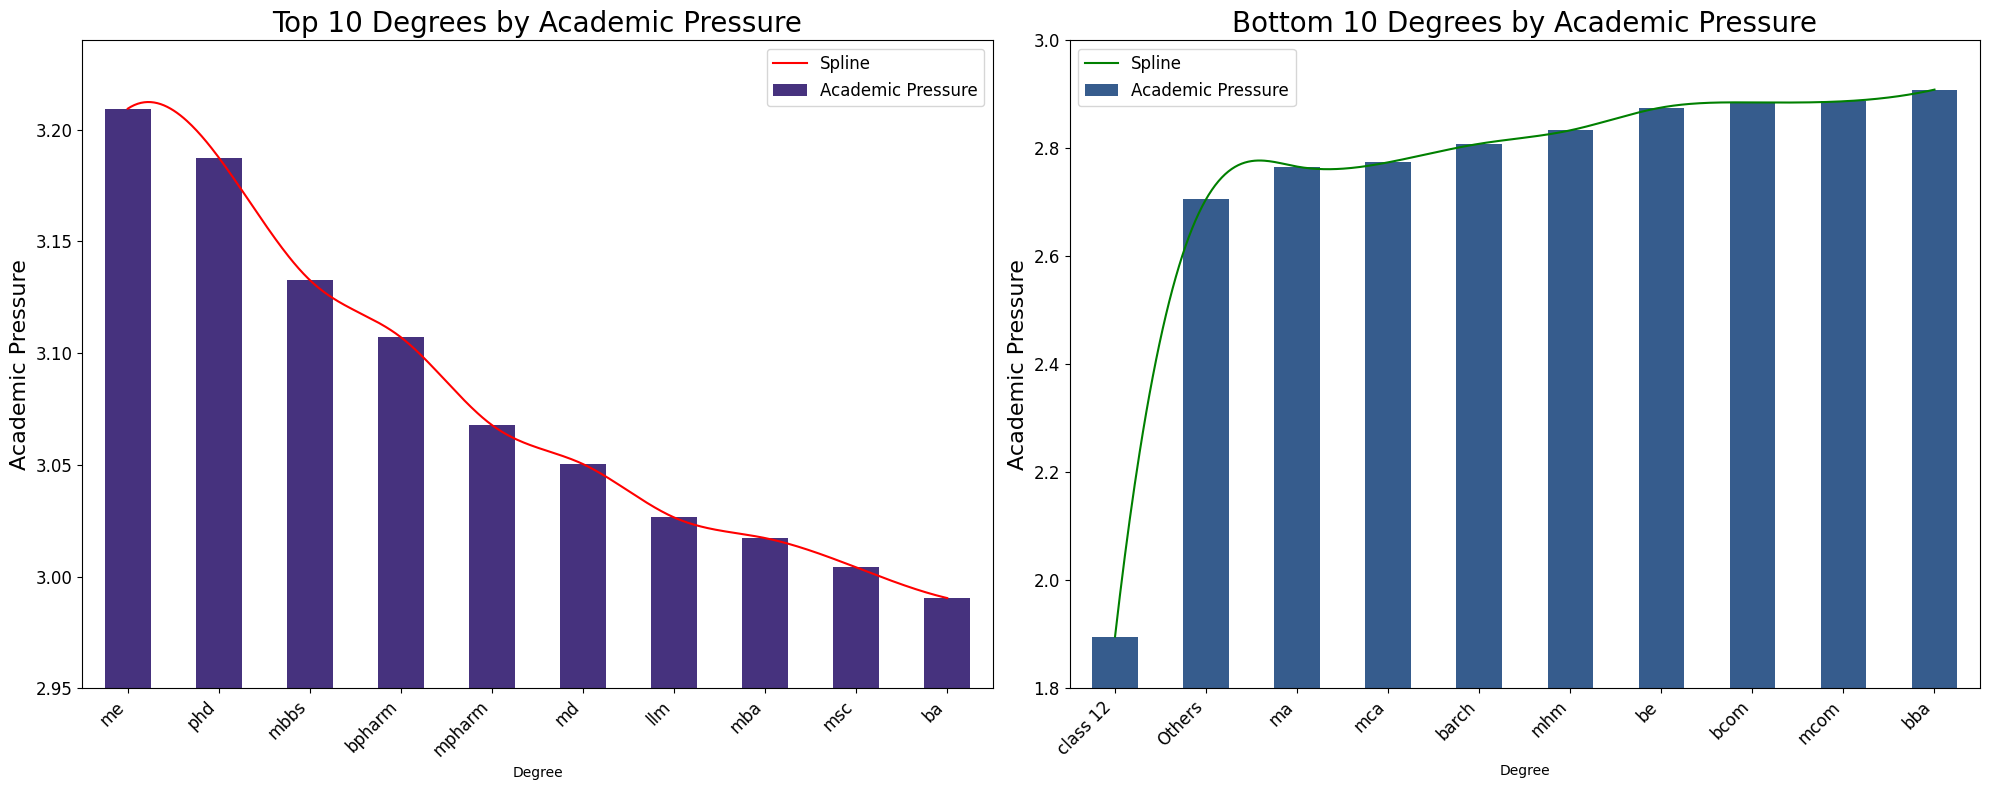

In [102]:
# Calculate top_degrees_ap and bottom_degrees_ap 
degree_stats_ap = student_df.groupby('Degree')['Academic Pressure'].mean().dropna()
degree_stats_ap = degree_stats_ap[degree_stats_ap.index.isin(student_df['Degree'].unique())]
top_degrees_ap = degree_stats_ap.nlargest(10)
bottom_degrees_ap = degree_stats_ap.nsmallest(10)


def spline_interpolation(ax, data, color):
    x = np.arange(len(data))
    y = data.values
    f = interp1d(x, y, kind='cubic')

    x_new = np.linspace(x.min(), x.max(), 500)
    y_new = f(x_new)

    ax.plot(x_new, y_new, color=color, linestyle='-', label="Spline")
    return ax


plt.figure(figsize=(20,8))

# Plotting Top Degrees
plt.subplot(1, 2, 1)
ax1 = top_degrees_ap.plot(kind='bar', color=sns.color_palette('viridis')[0])
ax1 = spline_interpolation(ax1, top_degrees_ap, 'red')
plt.title("Top 10 Degrees by Academic Pressure", fontsize=20) # Added fontsize
plt.ylabel("Academic Pressure", fontsize=16) # Added fontsize
plt.xticks(rotation=45, ha='right', fontsize=12) # Added fontsize
plt.yticks(fontsize=12) # Added fontsize
plt.ylim(2.95, 3.24)
plt.legend(fontsize=12) # Added fontsize


# Plotting Bottom Degrees
plt.subplot(1, 2, 2)
ax2 = bottom_degrees_ap.plot(kind='bar', color=sns.color_palette('viridis')[1])
ax2 = spline_interpolation(ax2, bottom_degrees_ap, 'green')
plt.title("Bottom 10 Degrees by Academic Pressure", fontsize=20) # Added fontsize
plt.ylabel("Academic Pressure", fontsize=16) # Added fontsize
plt.xticks(rotation=45, ha='right', fontsize=12) # Added fontsize
plt.yticks(fontsize=12) # Added fontsize
plt.ylim(1.8, 3)
plt.legend(fontsize=12) # Added fontsize


plt.tight_layout()
plt.show()

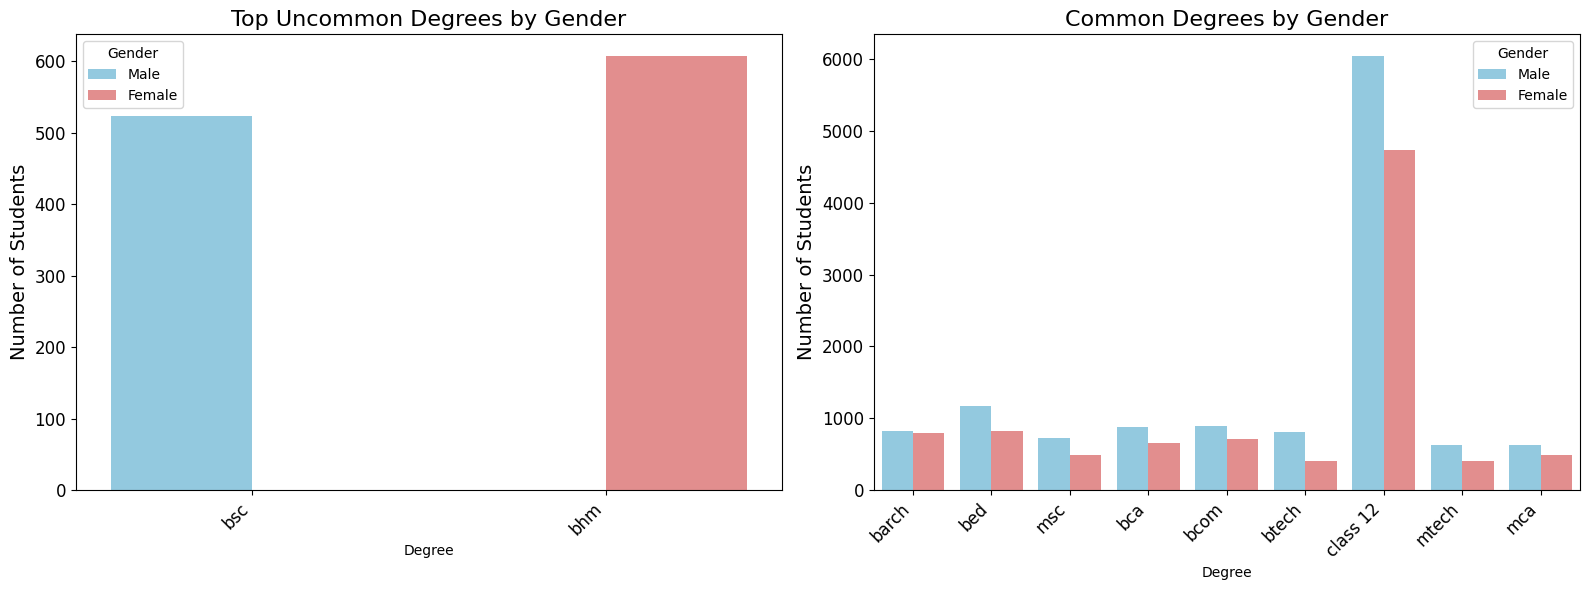

In [103]:
# Gender and Degree Analysis (Uncommon and Common Degrees with Gender Breakdown)
plt.figure(figsize=(16, 6))

top_degrees_male = student_df[student_df['Gender'] == 'Male']['Degree'].value_counts().nlargest(10)
top_degrees_female = student_df[student_df['Gender'] == 'Female']['Degree'].value_counts().nlargest(10)
common_degrees = list(set(top_degrees_male.index) & set(top_degrees_female.index))

# Uncommon Degrees for Males and Females
uncommon_male = top_degrees_male[~top_degrees_male.index.isin(common_degrees)]
uncommon_female = top_degrees_female[~top_degrees_female.index.isin(common_degrees)]

# Create a DataFrame for plotting (uncommon)
uncommon_df = pd.DataFrame({
    'Degree': uncommon_male.index.tolist() + uncommon_female.index.tolist(),
    'Gender': ['Male'] * len(uncommon_male) + ['Female'] * len(uncommon_female),
    'Count': uncommon_male.values.tolist() + uncommon_female.values.tolist()
})

# Create a DataFrame for plotting (common) WITH GENDER
common_df = pd.DataFrame()
for degree in common_degrees:
    male_count = student_df[(student_df['Gender'] == 'Male') & (student_df['Degree'] == degree)].shape[0]
    female_count = student_df[(student_df['Gender'] == 'Female') & (student_df['Degree'] == degree)].shape[0]
    common_df = pd.concat([common_df, pd.DataFrame({
        'Degree': [degree, degree],
        'Gender': ['Male', 'Female'],
        'Count': [male_count, female_count]
    })], ignore_index=True)



# Plotting Uncommon Degrees with Gender Breakdown
plt.subplot(1, 2, 1)
sns.barplot(x='Degree', y='Count', hue='Gender', data=uncommon_df, palette=['skyblue', 'lightcoral'])
plt.title('Top Uncommon Degrees by Gender', fontsize=16)
plt.ylabel("Number of Students", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Plotting Common Degrees WITH Gender Breakdown
plt.subplot(1, 2, 2)
sns.barplot(x='Degree', y='Count', hue='Gender', data=common_df, palette=['skyblue', 'lightcoral']) # Use barplot with hue
plt.title('Common Degrees by Gender', fontsize=16)
plt.ylabel("Number of Students", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

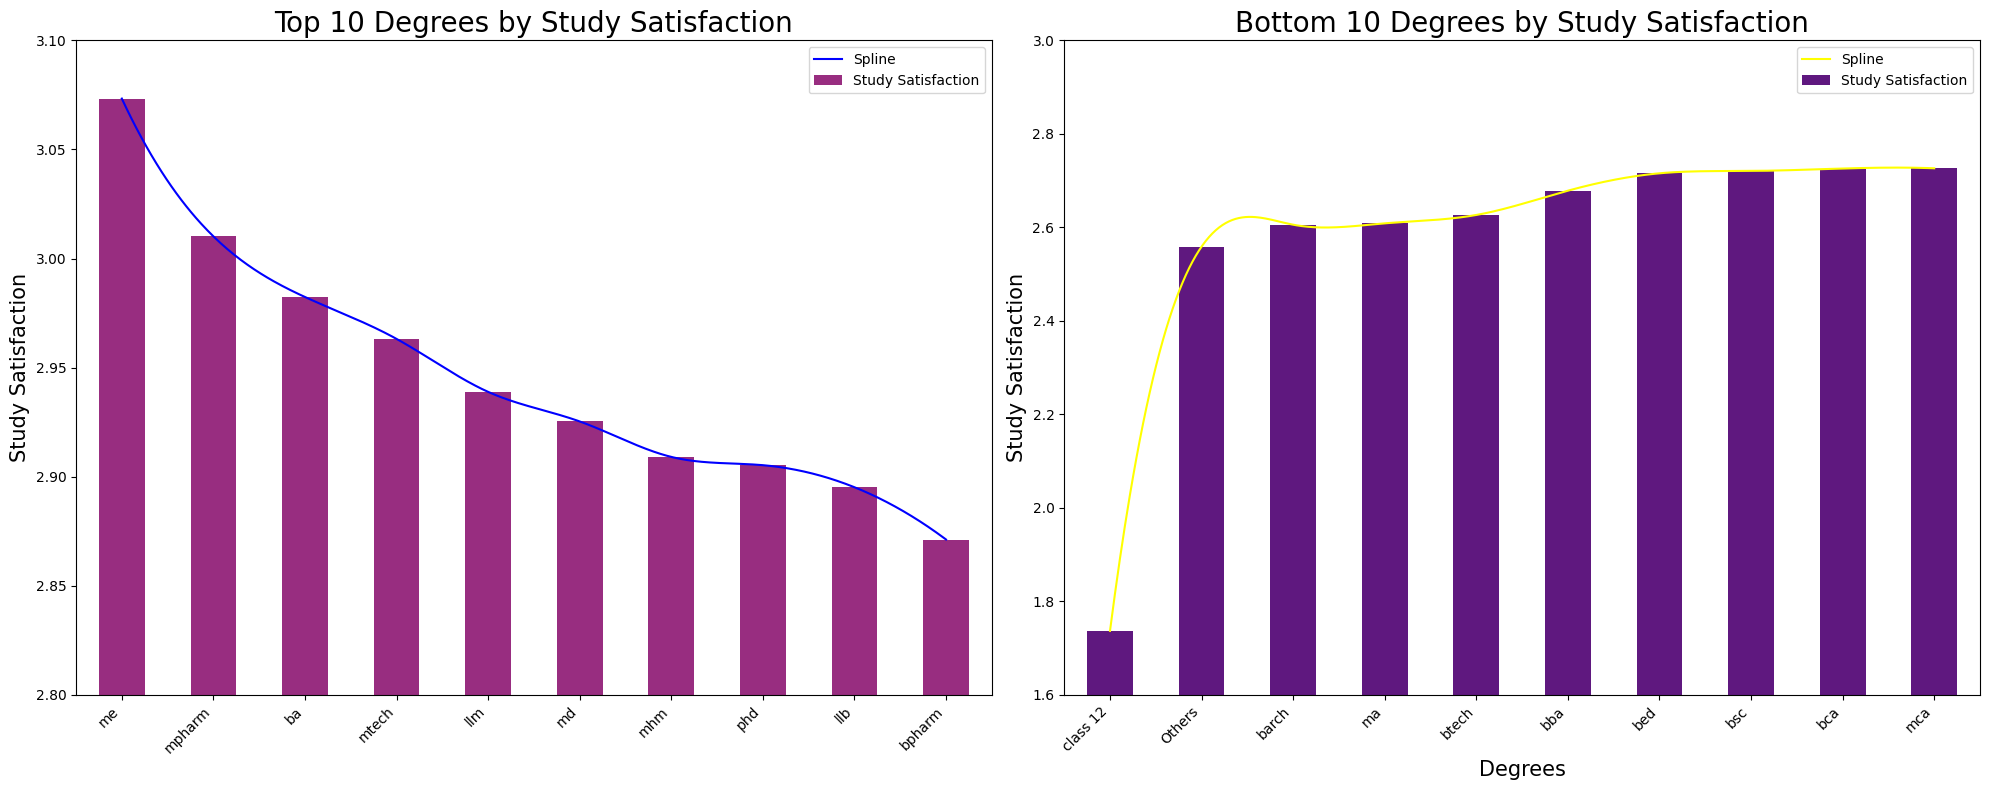

In [104]:
# Plotting Study Satisfaction
plt.figure(figsize=(20, 8))
degree_stats_ss = student_df.groupby('Degree')['Study Satisfaction'].mean().dropna()
degree_stats_ss = degree_stats_ss[degree_stats_ss.index.isin(student_df['Degree'].unique())]
top_degrees_ss = degree_stats_ss.nlargest(10)
bottom_degrees_ss = degree_stats_ss.nsmallest(10)

plt.subplot(1, 2, 1)
ax1 = top_degrees_ss.plot(kind='bar', color=sns.color_palette('magma')[2]) # Different color palette
ax1 = spline_interpolation(ax1,top_degrees_ss, 'blue')
plt.title("Top 10 Degrees by Study Satisfaction",fontsize=20)
plt.ylabel("Study Satisfaction",fontsize=15)
plt.xlabel("")
plt.ylim(2.8,3.1)
plt.xticks(rotation=45, ha='right')
plt.legend()


plt.subplot(1, 2, 2)
ax2 = bottom_degrees_ss.plot(kind='bar', color=sns.color_palette('magma')[1]) # Different color palette
ax2 = spline_interpolation(ax2,bottom_degrees_ss, 'yellow' )
plt.title("Bottom 10 Degrees by Study Satisfaction",fontsize=20)
plt.ylabel("Study Satisfaction",fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.ylim(1.6,3.0)
plt.xlabel("Degrees",fontsize=15)


plt.tight_layout()
plt.legend()

plt.show()

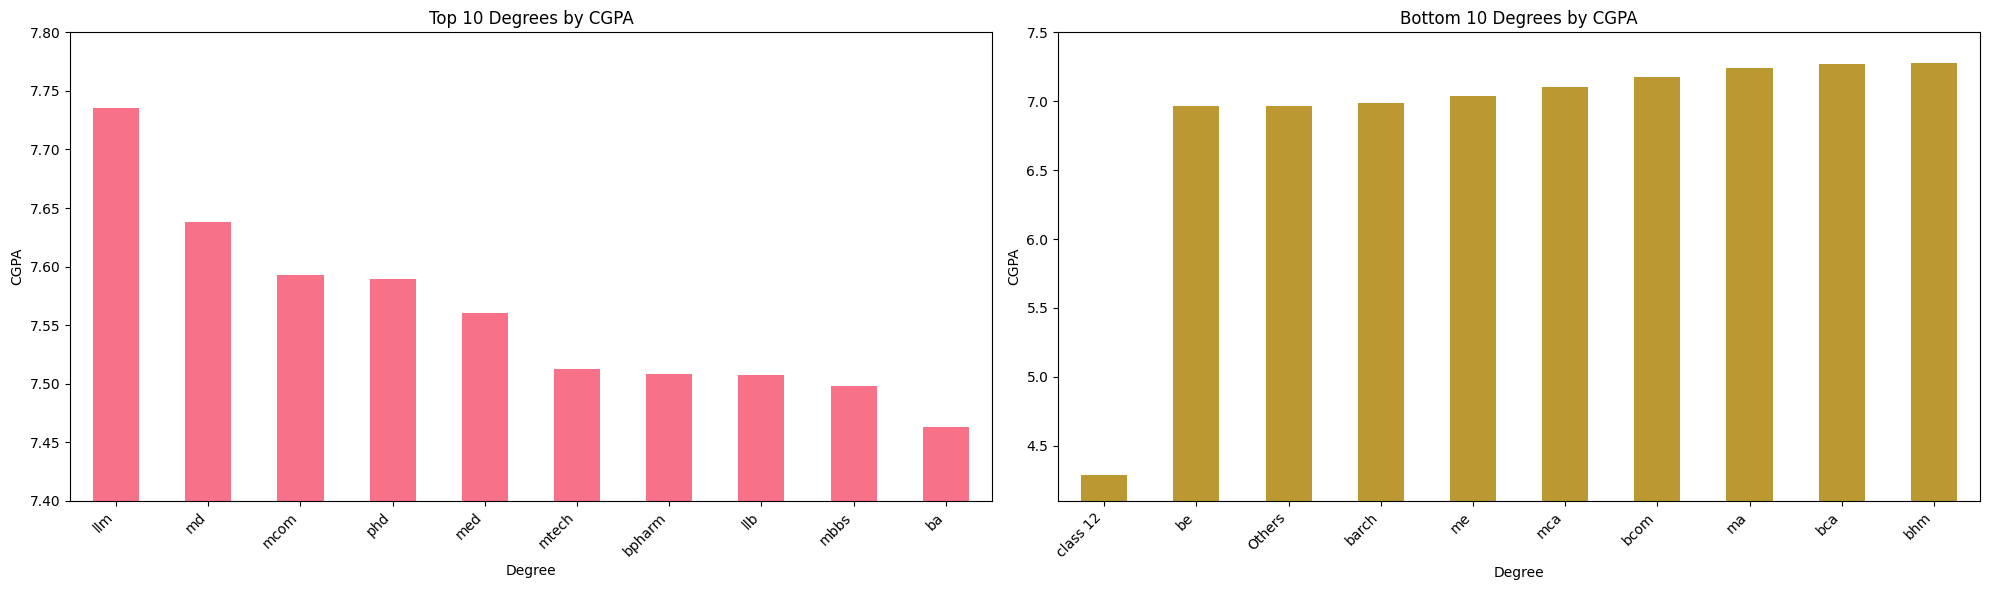

In [105]:
# CGPA Analysis
plt.figure(figsize=(20, 6))
degree_stats_cgpa = student_df.groupby('Degree')['CGPA'].mean().dropna()
degree_stats_cgpa = degree_stats_cgpa[degree_stats_cgpa.index.isin(student_df['Degree'].unique())]
top_degrees_cgpa = degree_stats_cgpa.nlargest(10)
bottom_degrees_cgpa = degree_stats_cgpa.nsmallest(10)

plt.subplot(1, 2, 1)
top_degrees_cgpa.plot(kind='bar', color=sns.color_palette('husl')[0])
plt.title("Top 10 Degrees by CGPA")
plt.ylabel("CGPA")
plt.xticks(rotation=45, ha='right')
plt.ylim(7.4,7.8)

plt.subplot(1, 2, 2)
bottom_degrees_cgpa.plot(kind='bar', color=sns.color_palette('husl')[1])
plt.title("Bottom 10 Degrees by CGPA")
plt.ylabel("CGPA")
plt.xticks(rotation=45, ha='right')
plt.ylim(4.1,7.5)

plt.tight_layout()
plt.show()

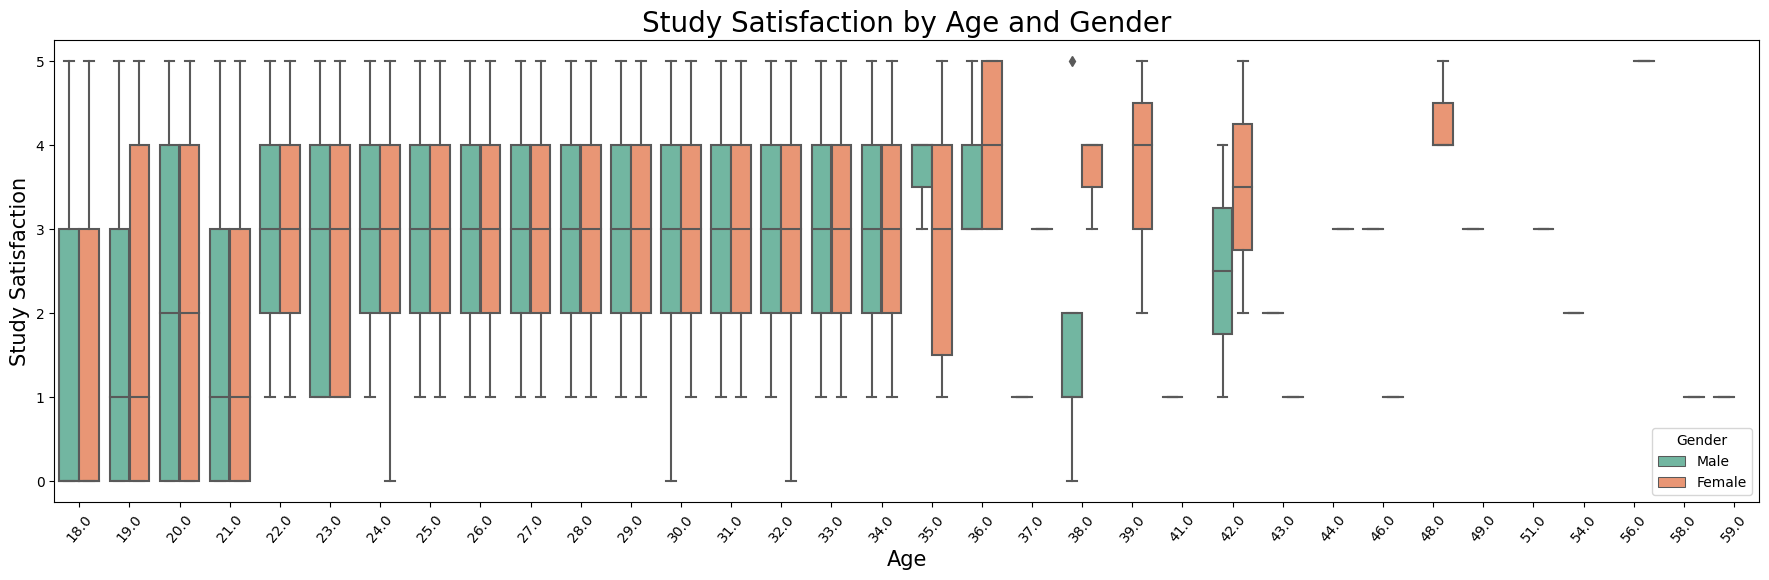

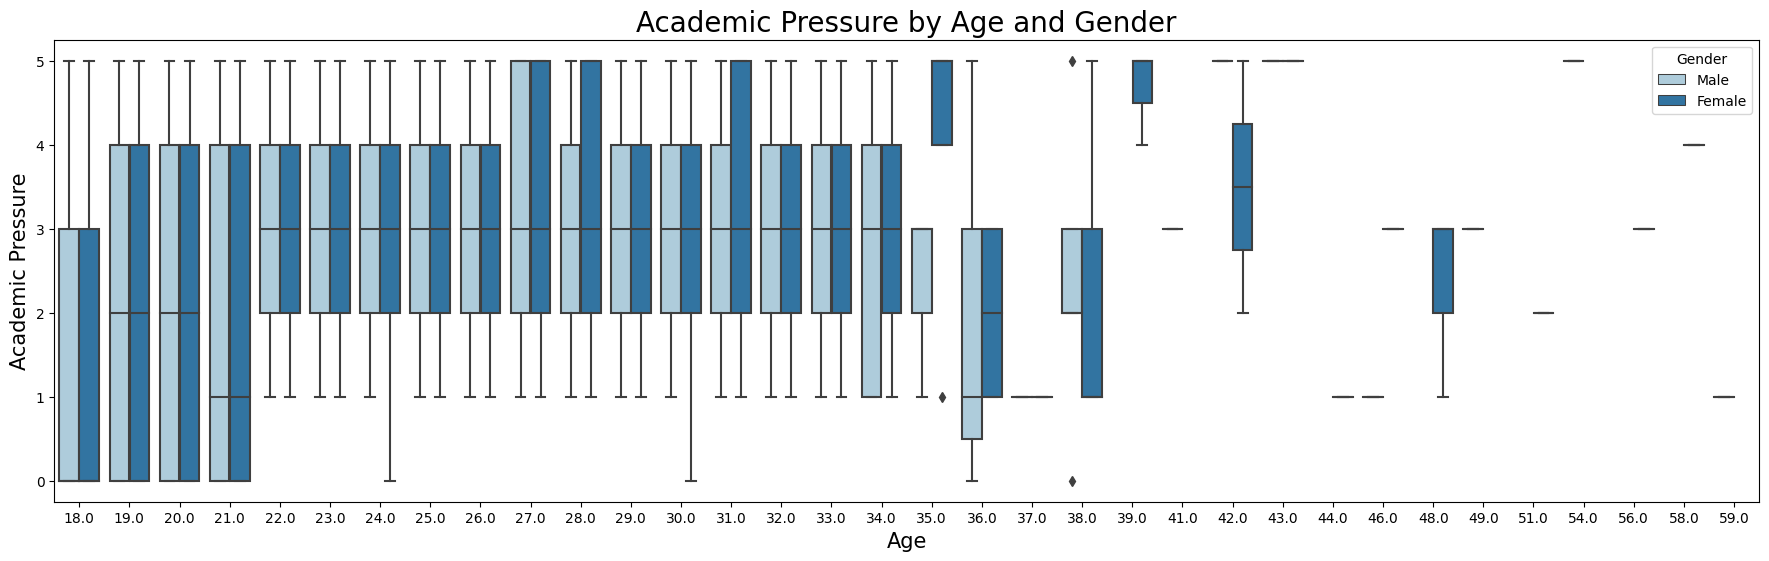

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


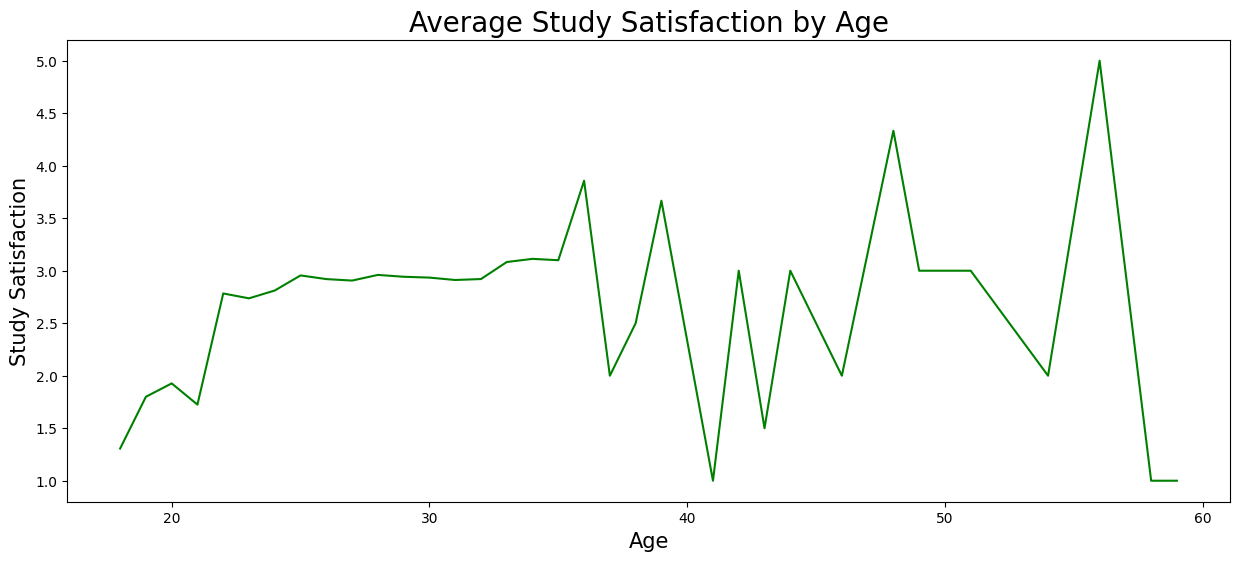

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


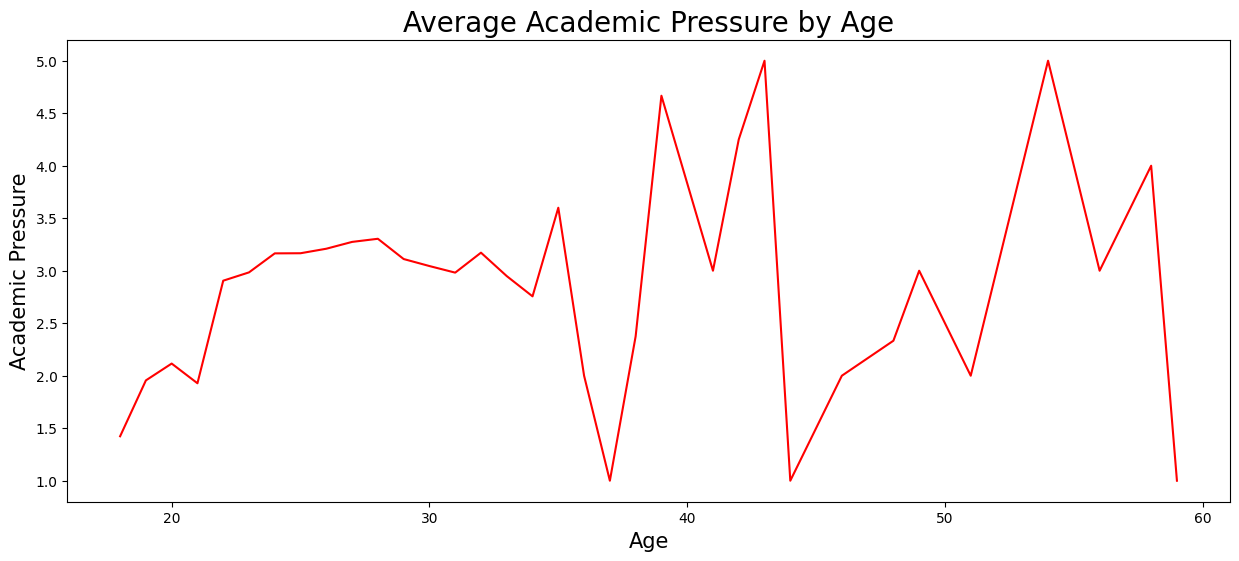

In [106]:
# Age, Gender, Study Satisfaction, and Academic Pressure Analysis (same as before)
plt.figure(figsize=(22, 6))
sns.boxplot(x='Age', y='Study Satisfaction', hue='Gender', data=student_df, palette="Set2") # Different palette
plt.title('Study Satisfaction by Age and Gender', fontsize=20)
plt.ylabel("Study Satisfaction",fontsize=15)
plt.xticks(rotation=50)
plt.xlabel("Age",fontsize=15)
plt.show()

plt.figure(figsize=(22, 6))
sns.boxplot(x='Age', y='Academic Pressure', hue='Gender', data=student_df, palette="Paired") # Different palette
plt.title('Academic Pressure by Age and Gender',fontsize=20)
plt.ylabel("Academic Pressure",fontsize=15)
plt.xlabel("Age",fontsize=15)
plt.show()

plt.figure(figsize=(15, 6))
sns.lineplot(x='Age', y='Study Satisfaction', data=student_df.groupby('Age')['Study Satisfaction'].mean().reset_index(), color = "green") # Different color
plt.title('Average Study Satisfaction by Age',fontsize=20)
plt.ylabel("Study Satisfaction",fontsize=15)
plt.xlabel("Age",fontsize=15)


plt.show()

plt.figure(figsize=(15, 6))
sns.lineplot(x='Age', y='Academic Pressure', data=student_df.groupby('Age')['Academic Pressure'].mean().reset_index(), color = "red") # Different color
plt.title('Average Academic Pressure by Age',fontsize=20)
plt.ylabel("Academic Pressure",fontsize=15)
plt.xlabel("Age",fontsize=15)

plt.show()

# Label Encoding

### encoding the labels for each columns

In [107]:
# train 
train_df.drop(columns=['id'],axis=1,inplace=True)
train_df.head(5)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,aaradhya,Female,49.0,ludhiana,Working Professional,chef,0.0,5.0,0.00,0.0,2.0,More than 8 hours,healthy,bhm,No,1.0,2.0,No,0
1,vivan,Male,26.0,varanasi,Working Professional,teacher,0.0,4.0,0.00,0.0,3.0,Less than 5 hours,unhealthy,llb,Yes,7.0,3.0,No,1
2,yuvraj,Male,33.0,visakhapatnam,Student,student,5.0,0.0,8.97,2.0,0.0,5-8 hours,healthy,bpharm,Yes,3.0,1.0,No,1
3,yuvraj,Male,22.0,mumbai,Working Professional,teacher,0.0,5.0,0.00,0.0,1.0,Less than 5 hours,moderate,bba,Yes,10.0,1.0,Yes,1
4,rhea,Female,30.0,kanpur,Working Professional,business analyst,0.0,1.0,0.00,0.0,1.0,5-8 hours,unhealthy,bba,Yes,9.0,4.0,Yes,0


In [108]:
test_df

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,
140700,shivam,Male,53.0,visakhapatnam,Working Professional,judge,0.0,2.0,0.00,0.0,5.0,Less than 5 hours,moderate,llb,No,9.0,3.0,Yes
140701,sanya,Female,58.0,kolkata,Working Professional,educational consultant,0.0,2.0,0.00,0.0,4.0,Less than 5 hours,moderate,bed,No,6.0,4.0,No
140702,yash,Male,53.0,jaipur,Working Professional,teacher,0.0,4.0,0.00,0.0,1.0,5-8 hours,moderate,barch,Yes,12.0,4.0,No
140703,nalini,Female,23.0,rajkot,Student,student,5.0,0.0,6.84,1.0,0.0,More than 8 hours,moderate,bsc,Yes,10.0,4.0,No
140704,shaurya,Male,47.0,kalyan,Working Professional,teacher,0.0,5.0,0.00,0.0,5.0,5-8 hours,moderate,bca,Yes,3.0,4.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234495,zoya,Female,49.0,jaipur,Working Professional,pilot,0.0,3.0,0.00,0.0,5.0,Less than 5 hours,moderate,bsc,Yes,2.0,2.0,Yes
234496,shlok,Male,29.0,ahmedabad,Working Professional,pilot,0.0,5.0,0.00,0.0,1.0,5-8 hours,moderate,be,Yes,11.0,3.0,Yes
234497,rishi,Male,24.0,visakhapatnam,Student,student,1.0,0.0,7.51,4.0,0.0,5-8 hours,moderate,btech,No,7.0,1.0,No


In [109]:
# dropping the name column from both train and test set
train_df.drop(columns=['Name','City'],axis=1,inplace=True)
test_df.drop(columns=['Name','City'],axis=1,inplace=True)


In [110]:
print(f"Train Set")
for i in train_df.columns:
    print(f"{i} : {train_df[i].unique()}")

print("+"*100)
print(f"Test Set")
for i in test_df.columns:
    print(f"{i} : {test_df[i].unique()}")

Train Set
Gender : ['Female' 'Male']
Age : [49. 26. 33. 22. 30. 59. 47. 38. 24. 42. 55. 51. 39. 29. 50. 23. 56. 45.
 37. 46. 31. 19. 28. 25. 41. 60. 18. 36. 21. 58. 44. 43. 40. 35. 54. 27.
 52. 48. 57. 53. 34. 20. 32.]
Working Professional or Student : ['Working Professional' 'Student']
Profession : ['chef' 'teacher' 'student' 'business analyst' 'finanancial analyst'
 'chemist' 'electrician' 'software engineer' 'data scientist' 'plumber'
 'marketing manager' 'accountant' 'entrepreneur' 'hr manager'
 'ux/ui designer' 'content writer' 'educational consultant'
 'civil engineer' 'manager' 'pharmacist' 'financial analyst' 'architect'
 'mechanical engineer' 'customer support' 'consultant' 'judge'
 'researcher' 'pilot' 'graphic designer' 'travel consultant'
 'digital marketer' 'lawyer' 'research analyst' 'sales executive' 'doctor'
 'Others' 'investment banker']
Academic Pressure : [0. 5. 2. 3. 4. 1.]
Work Pressure : [5. 4. 0. 1. 2. 3.]
CGPA : [ 0.      8.97    5.9     7.03    5.59    8.13    

In [111]:
train_df.columns

Index(['Gender', 'Age', 'Working Professional or Student', 'Profession',
       'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
       'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [112]:
new_train_df = train_df.copy()
new_test_df = test_df.copy()

new_train_df['Gender'] = LabelEncoder().fit_transform(new_train_df['Gender'])
new_test_df['Gender'] = LabelEncoder().fit_transform(new_test_df['Gender'])

new_train_df['Working Professional or Student'] = LabelEncoder().fit_transform(new_train_df['Working Professional or Student'])
new_test_df['Working Professional or Student'] = LabelEncoder().fit_transform(new_test_df['Working Professional or Student'])

new_train_df['Have you ever had suicidal thoughts ?'] = LabelEncoder().fit_transform(new_train_df['Have you ever had suicidal thoughts ?'])
new_test_df['Have you ever had suicidal thoughts ?'] = LabelEncoder().fit_transform(new_test_df['Have you ever had suicidal thoughts ?'])

new_train_df['Family History of Mental Illness'] = LabelEncoder().fit_transform(new_train_df['Family History of Mental Illness'])
new_test_df['Family History of Mental Illness'] = LabelEncoder().fit_transform(new_test_df['Family History of Mental Illness'])



In [113]:
new_train_df

,Gender,Age,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,49.0,1,chef,0.0,5.0,0.00,0.0,2.0,More than 8 hours,healthy,bhm,0,1.0,2.0,0,0
1,1,26.0,1,teacher,0.0,4.0,0.00,0.0,3.0,Less than 5 hours,unhealthy,llb,1,7.0,3.0,0,1
2,1,33.0,0,student,5.0,0.0,8.97,2.0,0.0,5-8 hours,healthy,bpharm,1,3.0,1.0,0,1
3,1,22.0,1,teacher,0.0,5.0,0.00,0.0,1.0,Less than 5 hours,moderate,bba,1,10.0,1.0,1,1
4,0,30.0,1,business analyst,0.0,1.0,0.00,0.0,1.0,5-8 hours,unhealthy,bba,1,9.0,4.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,0,18.0,1,student,0.0,5.0,0.00,0.0,4.0,5-8 hours,unhealthy,class 12,0,2.0,4.0,1,1
140696,0,41.0,1,content writer,0.0,5.0,0.00,0.0,4.0,5-8 hours,moderate,btech,1,6.0,5.0,1,0
140697,0,24.0,1,marketing manager,0.0,3.0,0.00,0.0,1.0,More than 8 hours,moderate,bcom,0,4.0,4.0,0,0
140698,0,49.0,1,plumber,0.0,5.0,0.00,0.0,2.0,5-8 hours,moderate,me,1,10.0,1.0,0,0


In [114]:

# --- Columns to Process ---
columns_to_process = ['Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']

# --- Initialize LabelEncoders (one for each column) ---
label_encoders = {}  # Dictionary to store LabelEncoders
for column in columns_to_process:
    label_encoders[column] = LabelEncoder()

# --- Process and Encode (Most Efficient Version)---
for column in columns_to_process:
    # Combine train and test data for consistent encoding and sorting
    combined_data = pd.concat([new_train_df[column], new_test_df[column]]).astype(str).str.lower()

    # Fit and transform on combined data, then split back
    categories = sorted(combined_data.unique())
    label_encoders[column].fit(categories)

    new_train_df[column] = label_encoders[column].transform(new_train_df[column].astype(str).str.lower())
    new_test_df[column] = label_encoders[column].transform(new_test_df[column].astype(str).str.lower())

    #Create Mappings
    mappings = {}
    mappings[column] = dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_)))


In [115]:
new_train_df.head()

,Gender,Age,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,49.0,1,3,0.0,5.0,0.00,0.0,2.0,2,0,7,0,1.0,2.0,0,0
1,1,26.0,1,34,0.0,4.0,0.00,0.0,3.0,1,3,12,1,7.0,3.0,0,1
2,1,33.0,0,33,5.0,0.0,8.97,2.0,0.0,0,0,8,1,3.0,1.0,0,1
3,1,22.0,1,34,0.0,5.0,0.00,0.0,1.0,1,1,2,1,10.0,1.0,1,1
4,0,30.0,1,2,0.0,1.0,0.00,0.0,1.0,0,3,2,1,9.0,4.0,1,0


In [116]:
new_test_df.head()

,Gender,Age,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,
140700,1,53.0,1,20,0.0,2.0,0.00,0.0,5.0,1,1,12,0,9.0,3.0,1
140701,0,58.0,1,12,0.0,2.0,0.00,0.0,4.0,1,1,6,0,6.0,4.0,0
140702,1,53.0,1,34,0.0,4.0,0.00,0.0,1.0,0,1,1,1,12.0,4.0,0
140703,0,23.0,0,33,5.0,0.0,6.84,1.0,0.0,2,1,9,1,10.0,4.0,0
140704,1,47.0,1,34,0.0,5.0,0.00,0.0,5.0,0,1,3,1,3.0,4.0,0


# Feature Extraction

In [117]:
# check if there are any duplicated field in train and test sets
print(f"Train Set Duplicated sum : {new_train_df.duplicated().sum()}")
print(f"Test Set Duplicated sum : {new_test_df.duplicated().sum()}")

Train Set Duplicated sum : 137
Test Set Duplicated sum : 73


In [118]:
# we will now remove the duplicated columns from the data
new_train_df.drop_duplicates(inplace=True)
new_test_df.drop_duplicates(inplace=True)

In [119]:
# We will also check if there are any null values present init again
print(new_train_df.isna().sum().sum())
print(new_test_df.isna().sum().sum())


0
0


In [120]:
# check if there are any duplicated field in train and test sets
print(f"Train Set Duplicated sum : {new_train_df.duplicated().sum()}")
print(f"Test Set Duplicated sum : {new_test_df.duplicated().sum()}")

Train Set Duplicated sum : 0
Test Set Duplicated sum : 0


In [121]:
# we will now divide the from the dependent and independent variables
X = new_train_df[['Gender','Age','Working Professional or Student','Profession','Academic Pressure','Work Pressure','CGPA','Study Satisfaction','Job Satisfaction',
                  'Sleep Duration','Dietary Habits','Degree','Have you ever had suicidal thoughts ?','Work/Study Hours','Financial Stress','Family History of Mental Illness']].copy()
y = new_train_df['Depression'].copy()

In [122]:
# Compute MI Scores
mi_scores = mutual_info_classif(X, y, discrete_features='auto', n_neighbors = 3, random_state=53)

# Store results in a DataFrame
mi_results = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_results = mi_results.sort_values(by='MI Score', ascending=False)  # Sort descending order

print(mi_results)

                                  Feature  MI Score
1                                     Age  0.199235
3                              Profession  0.138092
4                       Academic Pressure  0.137768
5                           Work Pressure  0.136779
2         Working Professional or Student  0.136765
8                        Job Satisfaction  0.128990
7                      Study Satisfaction  0.117419
6                                    CGPA  0.113697
12  Have you ever had suicidal thoughts ?  0.079185
11                                 Degree  0.039374
14                       Financial Stress  0.030734
13                       Work/Study Hours  0.024490
10                         Dietary Habits  0.019534
0                                  Gender  0.017047
15       Family History of Mental Illness  0.015826
9                          Sleep Duration  0.010695


In [123]:
# Compute MI Scores
mi_scores = mutual_info_classif(X, y, discrete_features='auto', n_neighbors = 5, random_state=53)

# Store results in a DataFrame
mi_results = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_results = mi_results.sort_values(by='MI Score', ascending=False)  # Sort descending order

print(mi_results)

                                  Feature  MI Score
1                                     Age  0.198612
4                       Academic Pressure  0.137642
3                              Profession  0.137199
5                           Work Pressure  0.134784
8                        Job Satisfaction  0.127510
2         Working Professional or Student  0.124516
7                      Study Satisfaction  0.116275
6                                    CGPA  0.114403
12  Have you ever had suicidal thoughts ?  0.073139
11                                 Degree  0.038114
14                       Financial Stress  0.029156
13                       Work/Study Hours  0.023081
10                         Dietary Habits  0.014754
0                                  Gender  0.007506
9                          Sleep Duration  0.007408
15       Family History of Mental Illness  0.006734


In [124]:
# Compute MI Scores
mi_scores = mutual_info_classif(X, y, discrete_features='auto', n_neighbors = 7, random_state=53)

# Store results in a DataFrame
mi_results = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_results = mi_results.sort_values(by='MI Score', ascending=False)  # Sort descending order

print(mi_results)


                                  Feature  MI Score
1                                     Age  0.198634
4                       Academic Pressure  0.137376
3                              Profession  0.136394
5                           Work Pressure  0.133136
8                        Job Satisfaction  0.126836
2         Working Professional or Student  0.120423
7                      Study Satisfaction  0.116521
6                                    CGPA  0.114061
12  Have you ever had suicidal thoughts ?  0.070507
11                                 Degree  0.037140
14                       Financial Stress  0.027933
13                       Work/Study Hours  0.022558
10                         Dietary Habits  0.013445
9                          Sleep Duration  0.006357
0                                  Gender  0.005474
15       Family History of Mental Illness  0.004439


As you can see from the column `MI Score`->  ***Mutual Information Score*** that features with low correlation and scores are often having imbalances while changing the number of neighbors for the evaluation of the **`features`** hence it is better to avoid features with **`MI Score`** less than **`0.01`**

**Columns** from the following will **NOT** **TO** **USE** as features :

1. `Sleep Duration`
2. `Family History of Mental Illness`
3. `Gender`

In [125]:
X.drop(columns=['Sleep Duration','Family History of Mental Illness','Gender'], axis=1, inplace=True)
X

,Age,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress
0,49.0,1,3,0.0,5.0,0.00,0.0,2.0,0,7,0,1.0,2.0
1,26.0,1,34,0.0,4.0,0.00,0.0,3.0,3,12,1,7.0,3.0
2,33.0,0,33,5.0,0.0,8.97,2.0,0.0,0,8,1,3.0,1.0
3,22.0,1,34,0.0,5.0,0.00,0.0,1.0,1,2,1,10.0,1.0
4,30.0,1,2,0.0,1.0,0.00,0.0,1.0,3,2,1,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,18.0,1,33,0.0,5.0,0.00,0.0,4.0,3,11,0,2.0,4.0
140696,41.0,1,7,0.0,5.0,0.00,0.0,4.0,1,10,1,6.0,5.0
140697,24.0,1,23,0.0,3.0,0.00,0.0,1.0,1,4,0,4.0,4.0
140698,49.0,1,28,0.0,5.0,0.00,0.0,2.0,1,21,1,10.0,1.0


In [126]:
Xtrial_df = new_test_df[['Age','Working Professional or Student','Profession','Academic Pressure','Work Pressure','CGPA','Study Satisfaction','Job Satisfaction',
                         'Degree','Have you ever had suicidal thoughts ?','Work/Study Hours','Financial Stress']].copy()
print(Xtrial_df.columns)


Index(['Age', 'Working Professional or Student', 'Profession',
       'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction',
       'Job Satisfaction', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress'],
      dtype='object')


In [127]:
Xtrial_df.duplicated().sum()

1192

In [128]:
Xtrial_df.drop_duplicates(inplace=True)

In [129]:
Xtrial_df.duplicated().sum()

0

In [130]:
Xtrial_df

,Age,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress
id,,,,,,,,,,,,
140700,53.0,1,20,0.0,2.0,0.00,0.0,5.0,12,0,9.0,3.0
140701,58.0,1,12,0.0,2.0,0.00,0.0,4.0,6,0,6.0,4.0
140702,53.0,1,34,0.0,4.0,0.00,0.0,1.0,1,1,12.0,4.0
140703,23.0,0,33,5.0,0.0,6.84,1.0,0.0,9,1,10.0,4.0
140704,47.0,1,34,0.0,5.0,0.00,0.0,5.0,3,1,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
234494,33.0,0,33,1.0,0.0,7.92,2.0,0.0,0,1,9.0,2.0
234495,49.0,1,27,0.0,3.0,0.00,0.0,5.0,9,1,2.0,2.0
234496,29.0,1,27,0.0,5.0,0.00,0.0,1.0,5,1,11.0,3.0


# Splitting the Data

In [131]:
X['Depression'] = y
X

,Age,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression
0,49.0,1,3,0.0,5.0,0.00,0.0,2.0,0,7,0,1.0,2.0,0
1,26.0,1,34,0.0,4.0,0.00,0.0,3.0,3,12,1,7.0,3.0,1
2,33.0,0,33,5.0,0.0,8.97,2.0,0.0,0,8,1,3.0,1.0,1
3,22.0,1,34,0.0,5.0,0.00,0.0,1.0,1,2,1,10.0,1.0,1
4,30.0,1,2,0.0,1.0,0.00,0.0,1.0,3,2,1,9.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,18.0,1,33,0.0,5.0,0.00,0.0,4.0,3,11,0,2.0,4.0,1
140696,41.0,1,7,0.0,5.0,0.00,0.0,4.0,1,10,1,6.0,5.0,0
140697,24.0,1,23,0.0,3.0,0.00,0.0,1.0,1,4,0,4.0,4.0,0
140698,49.0,1,28,0.0,5.0,0.00,0.0,2.0,1,21,1,10.0,1.0,0


In [132]:
X.duplicated().sum()

931

In [133]:
X.drop_duplicates(inplace=True)

In [134]:
X.shape

(139559, 14)

In [135]:
y = X['Depression']
y.shape

(139559,)

In [136]:
X.drop(columns=['Depression'], axis=1,inplace=True)

In [137]:
X.shape

(139559, 13)

In [138]:
y.shape

(139559,)

In [139]:
# splitting the train set and the test set to build the model to predict
X_train ,X_test, y_train , y_test = train_test_split(X,y,test_size=0.25, random_state=53)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (104669, 13)
X_test:  (34890, 13)
y_train:  (104669,)
y_test:  (34890,)
